In [86]:
%reload_ext autoreload
%autoreload 2

# Meta-analysis of benthic calcification rates

In [87]:
# custom imports
from calcification_meta_analysis.processing import process, climatology
from calcification_meta_analysis.plotting import (
    climatology as climatology_plot,
    analysis as analysis_plot,
    data_exploration,
    plot_utils,
    locations,
)
from calcification_meta_analysis.analysis import metafor, analysis
from calcification_meta_analysis.utils import config

# generic
import pandas as pd
import geopandas as gpd

### Load calcification rates dataset

#### Processing steps

1. Carbonate chemistry calculation from measured parameters
2. Populating location information (from coordinates, or where unavailable, fetching from the Google Maps API)
3. Assigning treatment and control groups (minimum pH, maximum temperature, unless otherwise specified)
4. Calculating effect sizes

In [88]:
calcification_data_df = process.process_extracted_calcification_data(
    fp=config.data_dir / "extracted_calcification_data.xlsx",
    sheet_name="all_data",
)

INFO:calcification_meta_analysis.processing.locations:Using cached locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/resources/gmaps_locations.yaml
INFO:calcification_meta_analysis.processing.locations:Dropped 151 row(s) for which latitude or longitude is NaN
INFO:calcification_meta_analysis.processing.taxonomy:Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/resources/species_mapping.yaml
INFO:calcification_meta_analysis.processing.cleaning:Unit standardization complete: 4518/4518 rows converted successfully
INFO:calcification_meta_analysis.processing.carbonate_processing:Loading measured values...
INFO:calcification_meta_analysis.processing.carbonate_processing:Calculated 1038 missing pHt value(s) using pHnbs/pHsws
INFO:calcification_meta_analysis.processing.ca

Calculating carbonate chemistry:   0%|          | 0/4669 [00:00<?, ?it/s]

INFO:calcification_meta_analysis.processing.carbonate_processing:Filled 18497.0 NaN values by combining dataframes


Total number of samples: 16910.0


Assigning treatment groups:   0%|          | 0/365 [00:00<?, ?it/s]

Skipping 10.1371/journal.pone.0075049 because it has only one treatment (no control)
Skipping 10.7717/peerj.411_2009-LOC-A because it has only one treatment (no control)
Skipping 10.7717/peerj.411_2009-LOC-B because it has only one treatment (no control)
Skipping 10.7717/peerj.411_2010-LOC-A because it has only one treatment (no control)
Skipping 10.7717/peerj.411_2010-LOC-B because it has only one treatment (no control)
Removing 1 row with n=1


  0%|          | 0/158 [00:00<?, ?it/s]

Saved to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/data/analysis_ready_calcification_data.csv


/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/analysis/analysis.py:356: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(0, mean_value).infer_objects(copy=False)


In [89]:
# generate the calcification meta-data
print("Number of unique studies:", calcification_data_df.original_doi.nunique())
print(
    "Number of unique sampling locations:",
    len(calcification_data_df.groupby(["latitude", "longitude"])),
)
print(f"Number of effect sizes: {len(calcification_data_df)}")

Number of unique studies: 136
Number of unique sampling locations: 122
Number of effect sizes: 1171


### Effect type choices

In [90]:
EFFECT_TYPE = "st_relative_calcification"

### Compare Python and native R compatability

The following cells train a few `metafor` models with different inputs, allowing comparison with identical models in the `alcification_meta_analysis/analysis/rnative/analysis.R` script (section starting at line 56).

The dataset is truncated to the first 200 rows to speed up model fitting.

The `metafor.MetaforModel` class is later used to forecast the calcification response to future climatology values.

Note: the native Python implementation of the Cook's distance calculation uses a simple Ordinary Least Squares (OLS) model rather than the `metafor` random mixed effects model. The latter is more robust, but is much more computationally intensive. While this notebook therefore doesn't exclude by Cooks distance by default, the final results (Figures 2, S7, S9, S10) in the paper use the `metafor` version. The `metafor` functionality can be toggled using `cooks_distance_type="native"` while the Python simplification is toggled using `cooks_distance_type="OLS"`. 

In [91]:
# raw model (no moderators) (line 62)
metafor_model = metafor.MetaforModel(
    calcification_data_df,
    # calcification_data_df.head(200),
    effect_type=EFFECT_TYPE,
    formula=f"{EFFECT_TYPE} ~ 1",
    random="~ 1 | doi",
    cooks_distance_type=None,  # can change to "OLS" to use the OLS method: but this is not implemented in the corresponding R script
).fit_model()
metafor_model.view_model_summary()

INFO:calcification_meta_analysis.analysis.metafor:R DataFrame created with 1171 rows
INFO:calcification_meta_analysis.analysis.metafor:Metafor initialized successfully
INFO:calcification_meta_analysis.analysis.metafor:Formula: st_relative_calcification ~ 1
INFO:calcification_meta_analysis.analysis.metafor:Treatment: ['phtot', 'temp', 'temp_phtot']
INFO:calcification_meta_analysis.analysis.metafor:Data shape: (1171, 89)
INFO:calcification_meta_analysis.analysis.metafor:Fitting model with formula: st_relative_calcification ~ 1



----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'temp_phtot']
Total samples in input data:  1171
Total samples of relevant investigation:  1171
Total samples dropped due to OLS Cook's distance:  0
Dropped due to NaN values:  0
Dropped due to Cook's distance:  0
Final sample count: 1171 (0 rows dropped)



  
  
  
INFO:calcification_meta_analysis.analysis.metafor:Extracted model components: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2']
INFO:calcification_meta_analysis.analysis.metafor:Model fitted successfully
INFO:calcification_meta_analysis.analysis.metafor:Components extracted: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2']



Multivariate Meta-Analysis Model (k = 1171; method: REML)

     logLik     Deviance          AIC          BIC         AICc   
-10338.8545   20677.7091   20681.7091   20691.8386   20681.7193   

Variance Components:

              estim     sqrt  nlvls  fixed  factor 
sigma^2    935.7419  30.5899    157     no     doi 

Test for Heterogeneity:
Q(df = 1170) = 23497.2783, p-val < .0001

Model Results:

estimate      se      zval    pval     ci.lb     ci.ub      
-33.5580  2.6716  -12.5612  <.0001  -38.7941  -28.3218  *** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




In [92]:
# moderators model (line 67)
metafor_model = metafor.MetaforModel(
    calcification_data_df.head(200),
    effect_type=EFFECT_TYPE,
    formula=f"{EFFECT_TYPE} ~ delta_t + delta_ph - 1",
    random="~ 1 | doi",
    cooks_distance_type=None,
).fit_model()
metafor_model.view_model_summary()

INFO:calcification_meta_analysis.analysis.metafor:R DataFrame created with 200 rows
INFO:calcification_meta_analysis.analysis.metafor:Metafor initialized successfully
INFO:calcification_meta_analysis.analysis.metafor:Formula: st_relative_calcification ~ delta_t + delta_ph - 1
INFO:calcification_meta_analysis.analysis.metafor:Treatment: ['phtot', 'temp', 'temp_phtot']
INFO:calcification_meta_analysis.analysis.metafor:Data shape: (200, 89)
INFO:calcification_meta_analysis.analysis.metafor:Fitting model with formula: st_relative_calcification ~ delta_t + delta_ph - 1



----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'temp_phtot']
Total samples in input data:  200
Total samples of relevant investigation:  200
Total samples dropped due to OLS Cook's distance:  0
Dropped due to NaN values:  0
Dropped due to Cook's distance:  0
Final sample count: 200 (0 rows dropped)



  
  
  
  
INFO:calcification_meta_analysis.analysis.metafor:Extracted model components: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2']
INFO:calcification_meta_analysis.analysis.metafor:Model fitted successfully
INFO:calcification_meta_analysis.analysis.metafor:Components extracted: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2']



Multivariate Meta-Analysis Model (k = 200; method: REML)

    logLik    Deviance         AIC         BIC        AICc   
-1405.8617   2811.7235   2817.7235   2827.5883   2817.8472   

Variance Components:

              estim     sqrt  nlvls  fixed  factor 
sigma^2    588.7620  24.2644     19     no     doi 

Test for Residual Heterogeneity:
QE(df = 198) = 1504.3478, p-val < .0001

Test of Moderators (coefficients 1:2):
QM(df = 2) = 176.3194, p-val < .0001

Model Results:

          estimate      se     zval    pval    ci.lb    ci.ub      
delta_t    -5.4303  0.7228  -7.5125  <.0001  -6.8470  -4.0136  *** 
delta_ph   42.2838  3.7558  11.2583  <.0001  34.9226  49.6450  *** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




In [93]:
# changing random effect structure (line 72)
metafor_model = metafor.MetaforModel(
    calcification_data_df.head(200),
    effect_type=EFFECT_TYPE,
    formula=f"{EFFECT_TYPE} ~ delta_t + delta_ph - 1",
    random="~ 1 | doi/ID",
    cooks_distance_type=None,
).fit_model()
metafor_model.view_model_summary()


INFO:calcification_meta_analysis.analysis.metafor:R DataFrame created with 200 rows
INFO:calcification_meta_analysis.analysis.metafor:Metafor initialized successfully
INFO:calcification_meta_analysis.analysis.metafor:Formula: st_relative_calcification ~ delta_t + delta_ph - 1
INFO:calcification_meta_analysis.analysis.metafor:Treatment: ['phtot', 'temp', 'temp_phtot']
INFO:calcification_meta_analysis.analysis.metafor:Data shape: (200, 89)
INFO:calcification_meta_analysis.analysis.metafor:Fitting model with formula: st_relative_calcification ~ delta_t + delta_ph - 1



----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'temp_phtot']
Total samples in input data:  200
Total samples of relevant investigation:  200
Total samples dropped due to OLS Cook's distance:  0
Dropped due to NaN values:  0
Dropped due to Cook's distance:  0
Final sample count: 200 (0 rows dropped)



  
  
  
  
INFO:calcification_meta_analysis.analysis.metafor:Extracted model components: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']
INFO:calcification_meta_analysis.analysis.metafor:Model fitted successfully
INFO:calcification_meta_analysis.analysis.metafor:Components extracted: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']



Multivariate Meta-Analysis Model (k = 200; method: REML)

    logLik    Deviance         AIC         BIC        AICc   
-1034.7661   2069.5321   2077.5321   2090.6852   2077.7394   

Variance Components:

              estim     sqrt  nlvls  fixed  factor 
sigma^2.1  529.6659  23.0145     19     no     doi 
sigma^2.2  972.0612  31.1779    200     no  doi/ID 

Test for Residual Heterogeneity:
QE(df = 198) = 1504.3478, p-val < .0001

Test of Moderators (coefficients 1:2):
QM(df = 2) = 41.0620, p-val < .0001

Model Results:

          estimate      se     zval    pval    ci.lb    ci.ub      
delta_t    -6.2679  1.6937  -3.7007  0.0002  -9.5874  -2.9483  *** 
delta_ph   52.2096  9.9665   5.2385  <.0001  32.6756  71.7436  *** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




### Load climatology data

INFO:root:Loading climatology data...
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcast

Generating batched anomalies for ph:   0%|          | 0/136 [00:00<?, ?it/s]

Generating batched anomalies for sst:   0%|          | 0/136 [00:00<?, ?it/s]

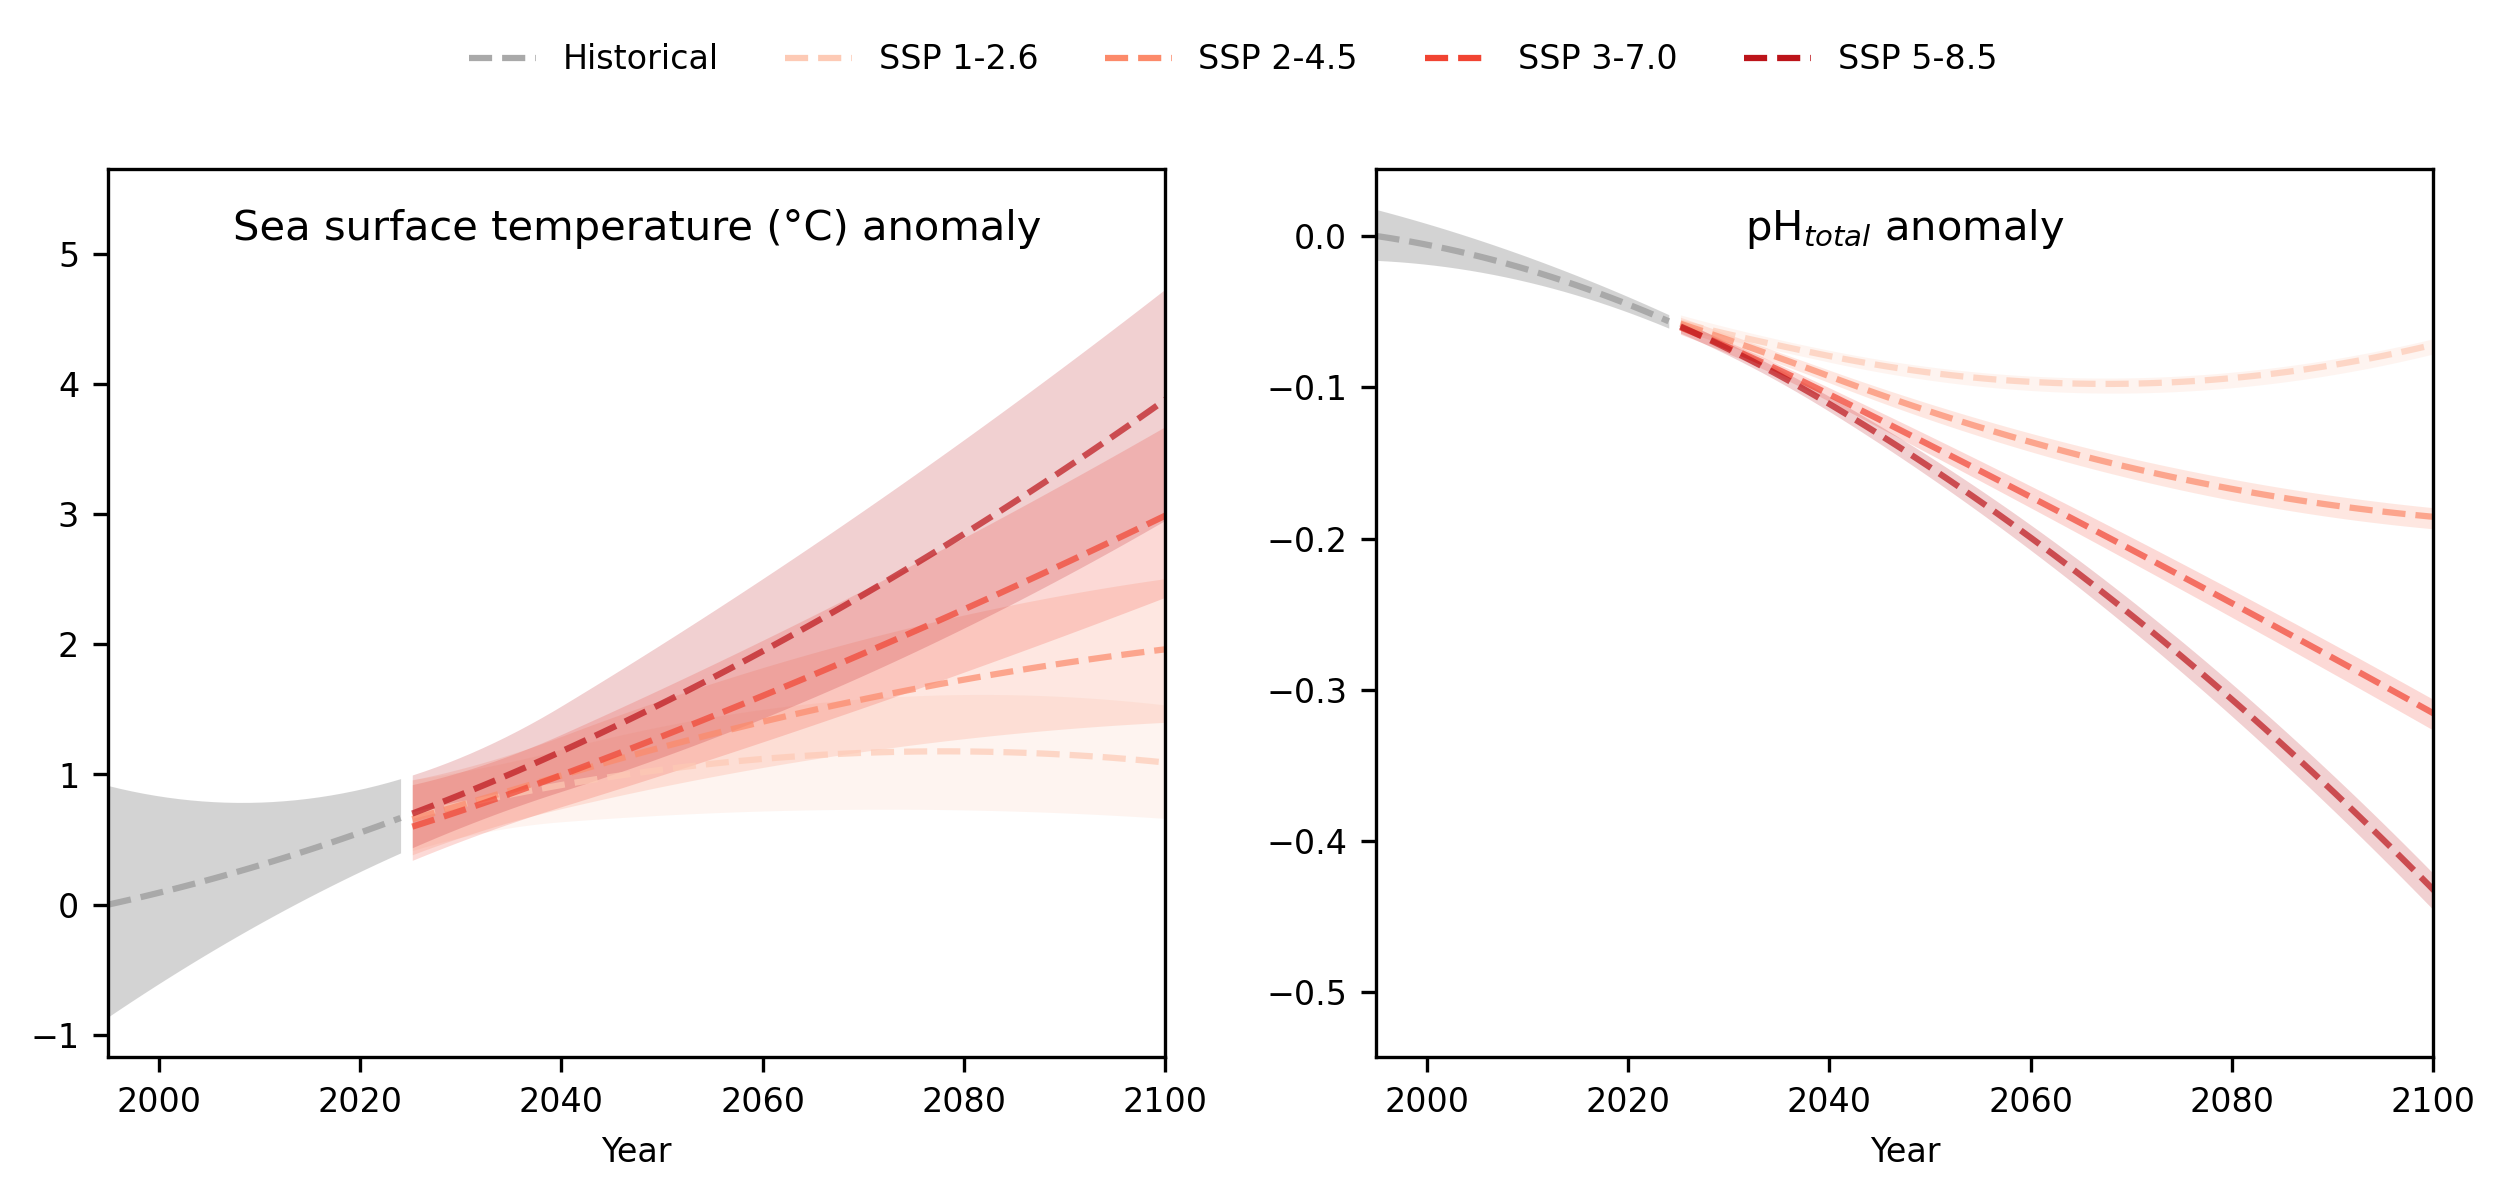

In [94]:
local_climatology_df, global_future_anomaly_df, global_anomaly_df = (
    process.process_climatology_data(
        calcification_data_df,
        config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
        config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
        config.resources_dir / "locations.yaml",
    )
)
# extrapolate climatology values to end of century
global_anomaly_df = climatology.extrapolate_df(global_anomaly_df)
# visualise climatologies until end of century
fig, ax = climatology_plot.plot_climate_anomalies(global_anomaly_df)

#### Filter measured calcification responses based on forecasted climatologies
To those lying within the limits of reasonable forecasts by the end of the century

-0.8617067196757783 4.725700984343634 -0.4454359177767929 0.017505629290729054


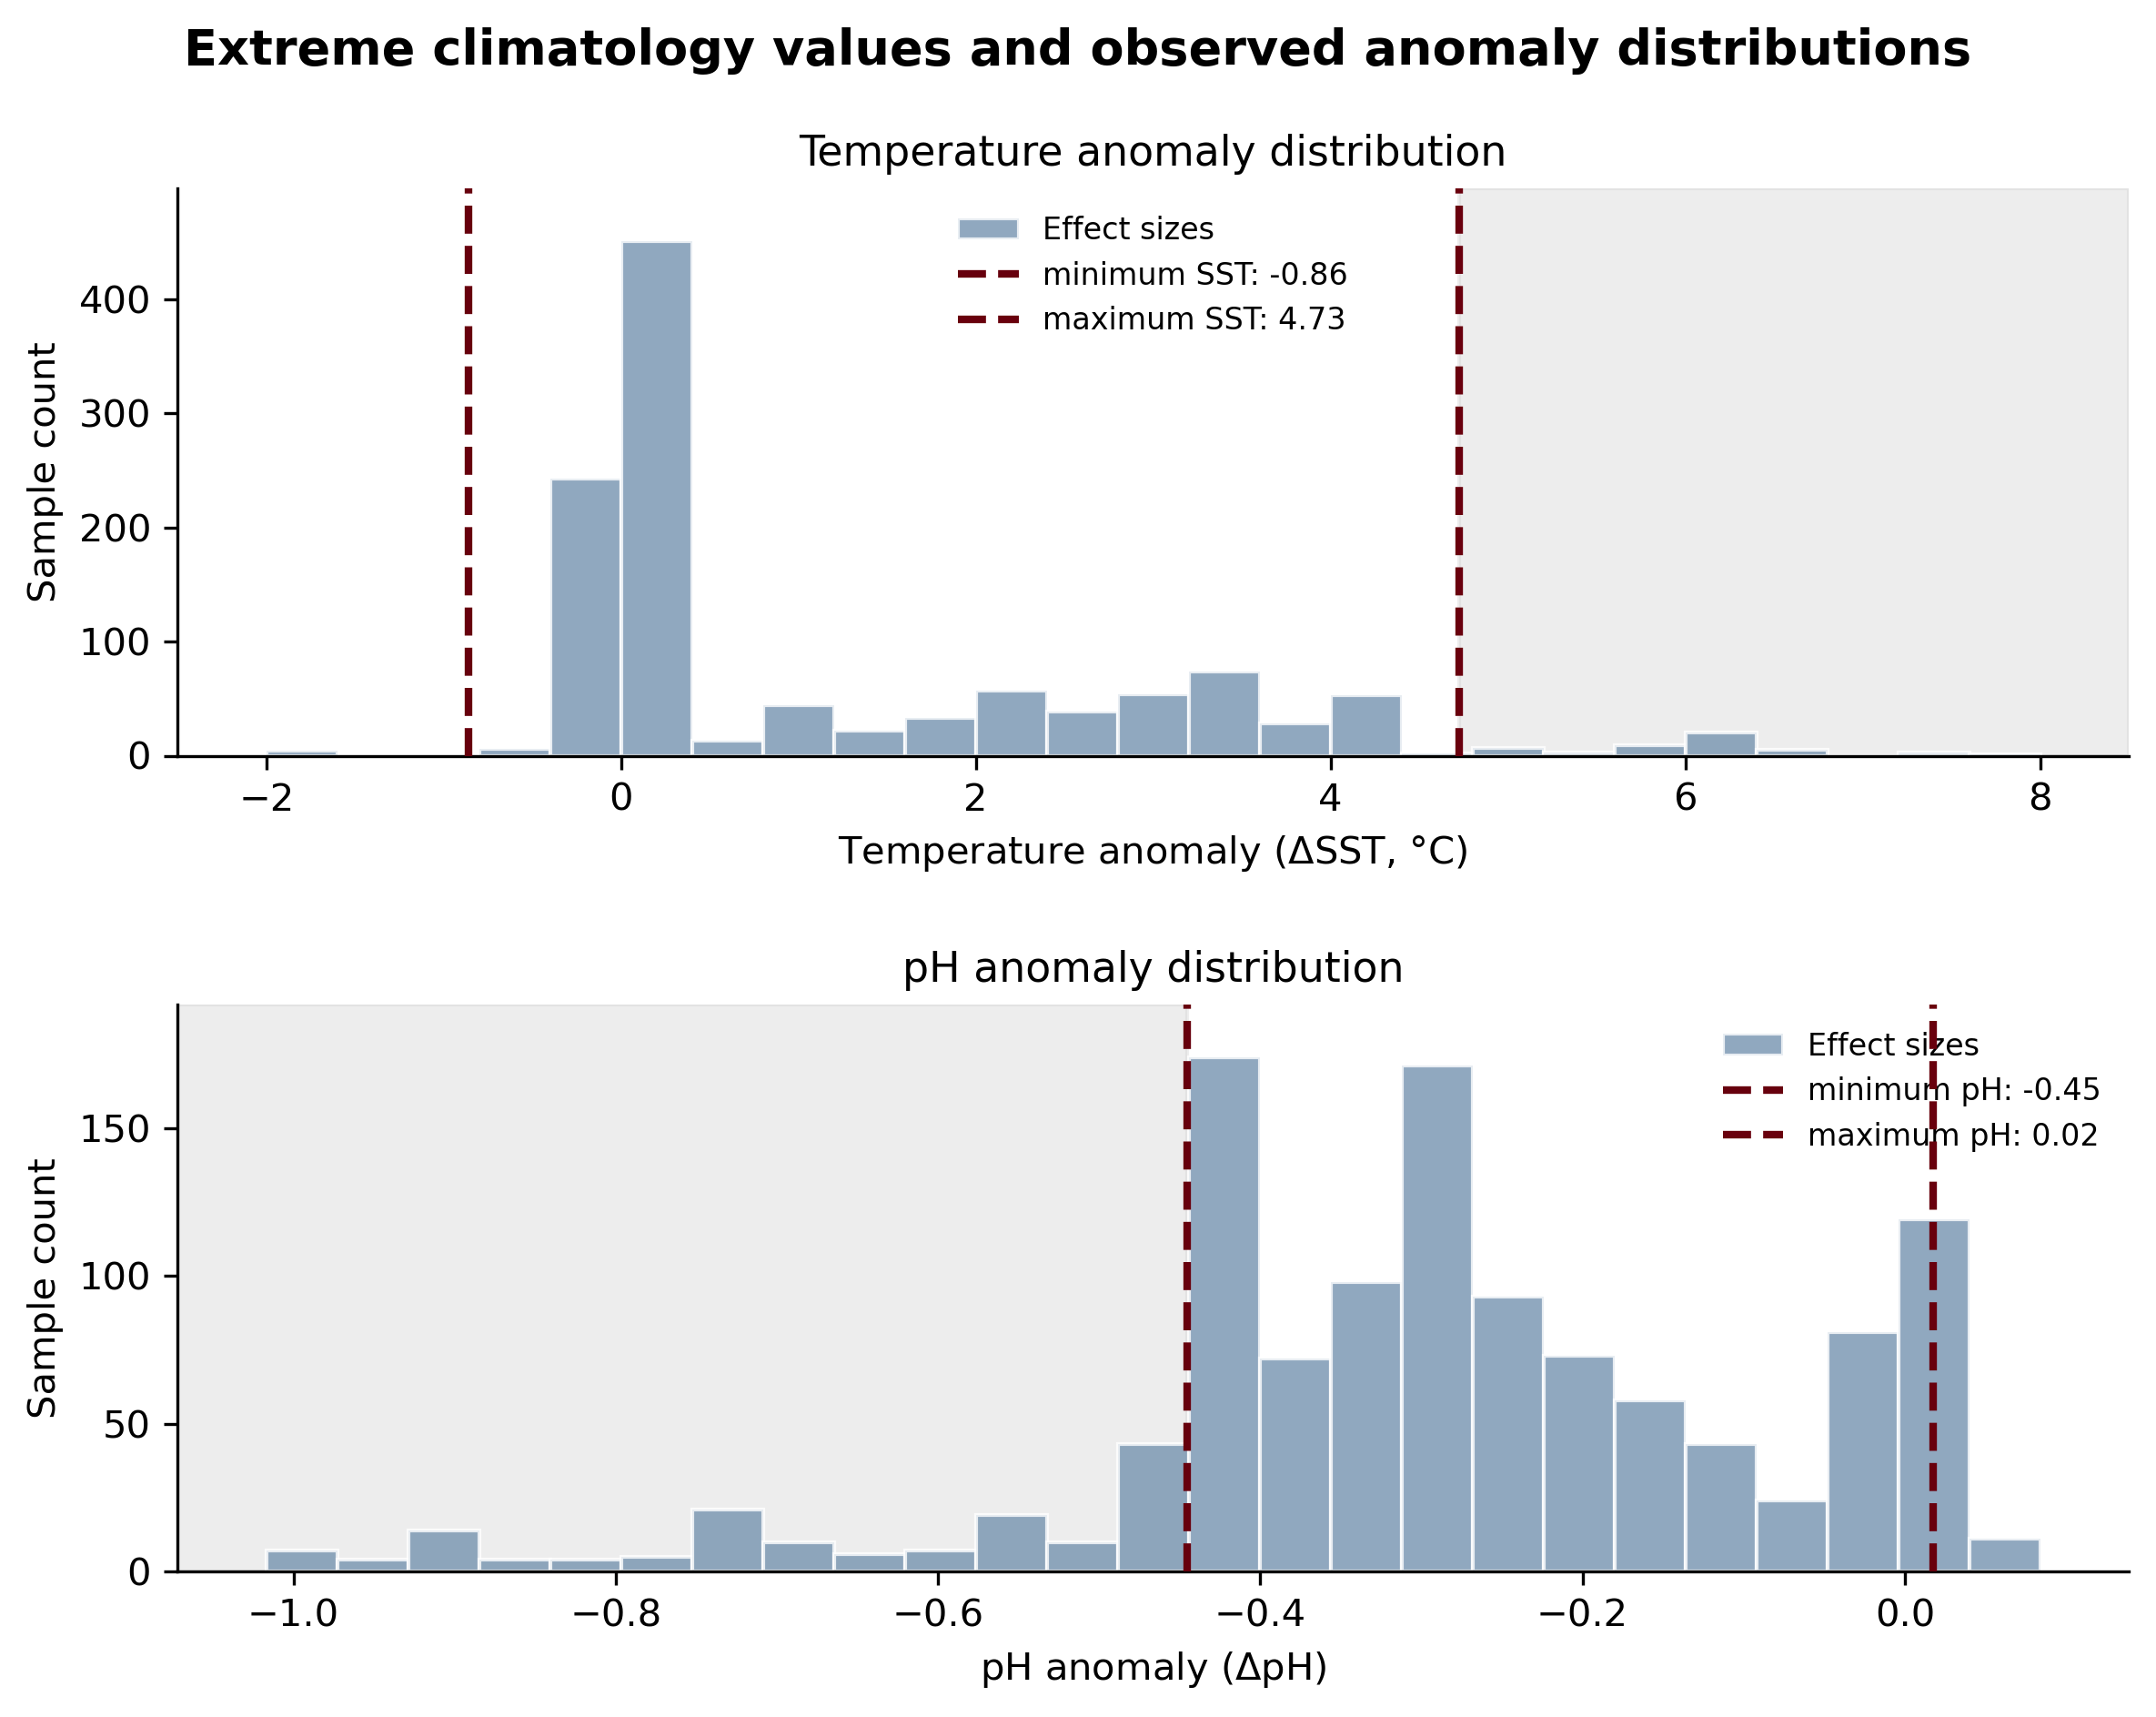

In [95]:
# filter for reasonable climatologies
calcification_clim_filtered_data_df = climatology.filter_df_by_extreme_climatologies(
    calcification_data_df, global_anomaly_df
)
fig, ax = climatology_plot.plot_extreme_climatology_values(
    calcification_data_df, global_anomaly_df
)

In [96]:
# generate the calcification meta-data of climate-filtered dataset
print(
    "Number of unique studies:",
    calcification_clim_filtered_data_df.original_doi.nunique(),
)
print(
    "Number of unique sampling locations:",
    len(calcification_clim_filtered_data_df.groupby(["latitude", "longitude"])),
)


Number of unique studies: 124
Number of unique sampling locations: 111


## Exploring distribution of effect size

### Figure S1 – Visualising distribution effect sizes against climate anomalies

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/plotting/data_exploration.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.set_ylabel("Number of studies", fontsize=plt.rcParams["font.size"])


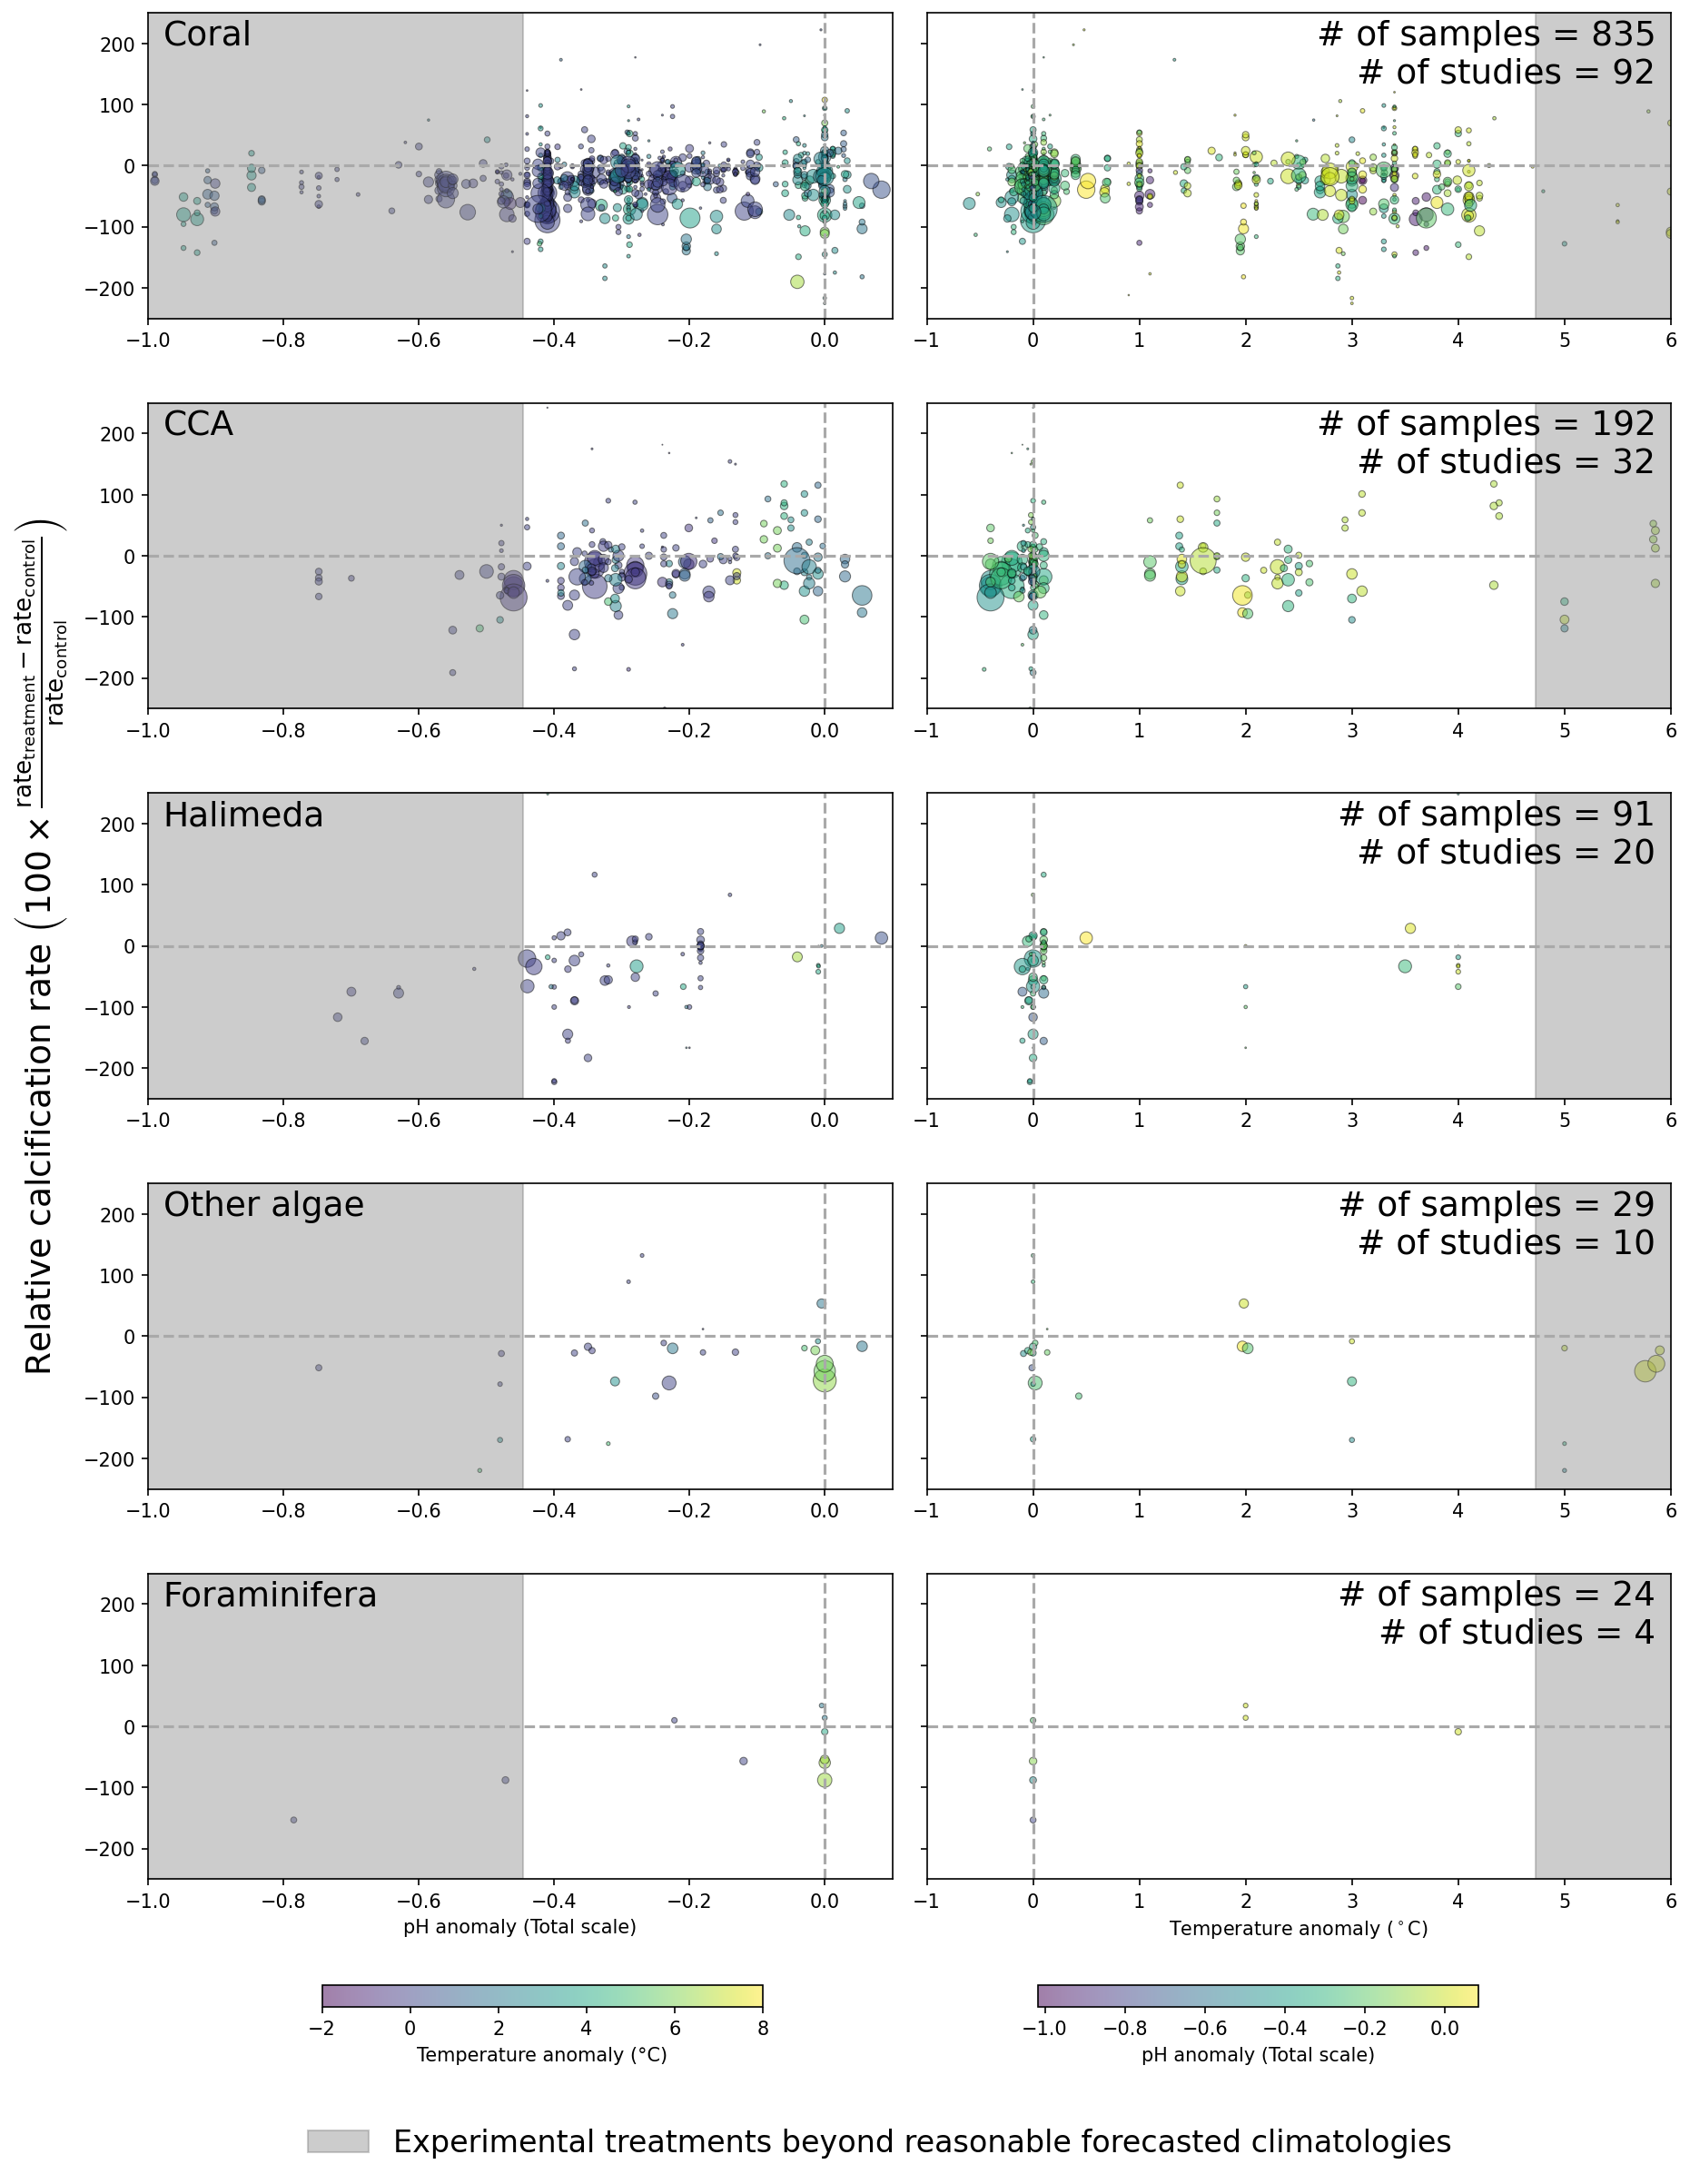

In [97]:
fig, ax = data_exploration.plot_core_grouping_scatter(
    calcification_data_df, global_anomaly_df
)
# plot_utils.save_fig(fig, "FIG_S1")

### Figure S2 – Effect of limiting treatment conditions on model fit

This analysis was run natively in R: see `line 76` of `calcification_meta_analysis/analysis/rnative/analysis.R`

### Figure S3 – Distribution of effect sizes

The Foraminifera category showed significant variation in coefficient estimation when fitting with all data points versus the climatologically filtered data. This was due to the small initial and post-filtering sample sizes and a single study dominating the Foraminifera data (62.5% of data points) which reported exceedingly large changes in calcification rate (mean change of –490% (2 s.f.)). The Foraminifera category was therefore excluded from further analysis.

In [98]:
calcification_clim_filtered_data_df = calcification_clim_filtered_data_df[
    calcification_clim_filtered_data_df.core_grouping != "Foraminifera"
]


# generate the calcification meta-data
print(
    "Number of unique studies:",
    calcification_clim_filtered_data_df.original_doi.nunique(),
)
print(
    "Number of unique sampling locations:",
    len(calcification_clim_filtered_data_df.groupby(["latitude", "longitude"])),
)
print(
    f"Number of effect sizes after filtering out extreme climatologies: {len(calcification_clim_filtered_data_df)}"
)
print(
    f"Number of samples under experiment (in treatment conditions): {int(calcification_clim_filtered_data_df.n.sum())}"
)

Number of unique studies: 122
Number of unique sampling locations: 109
Number of effect sizes after filtering out extreme climatologies: 926
Number of samples under experiment (in treatment conditions): 9152


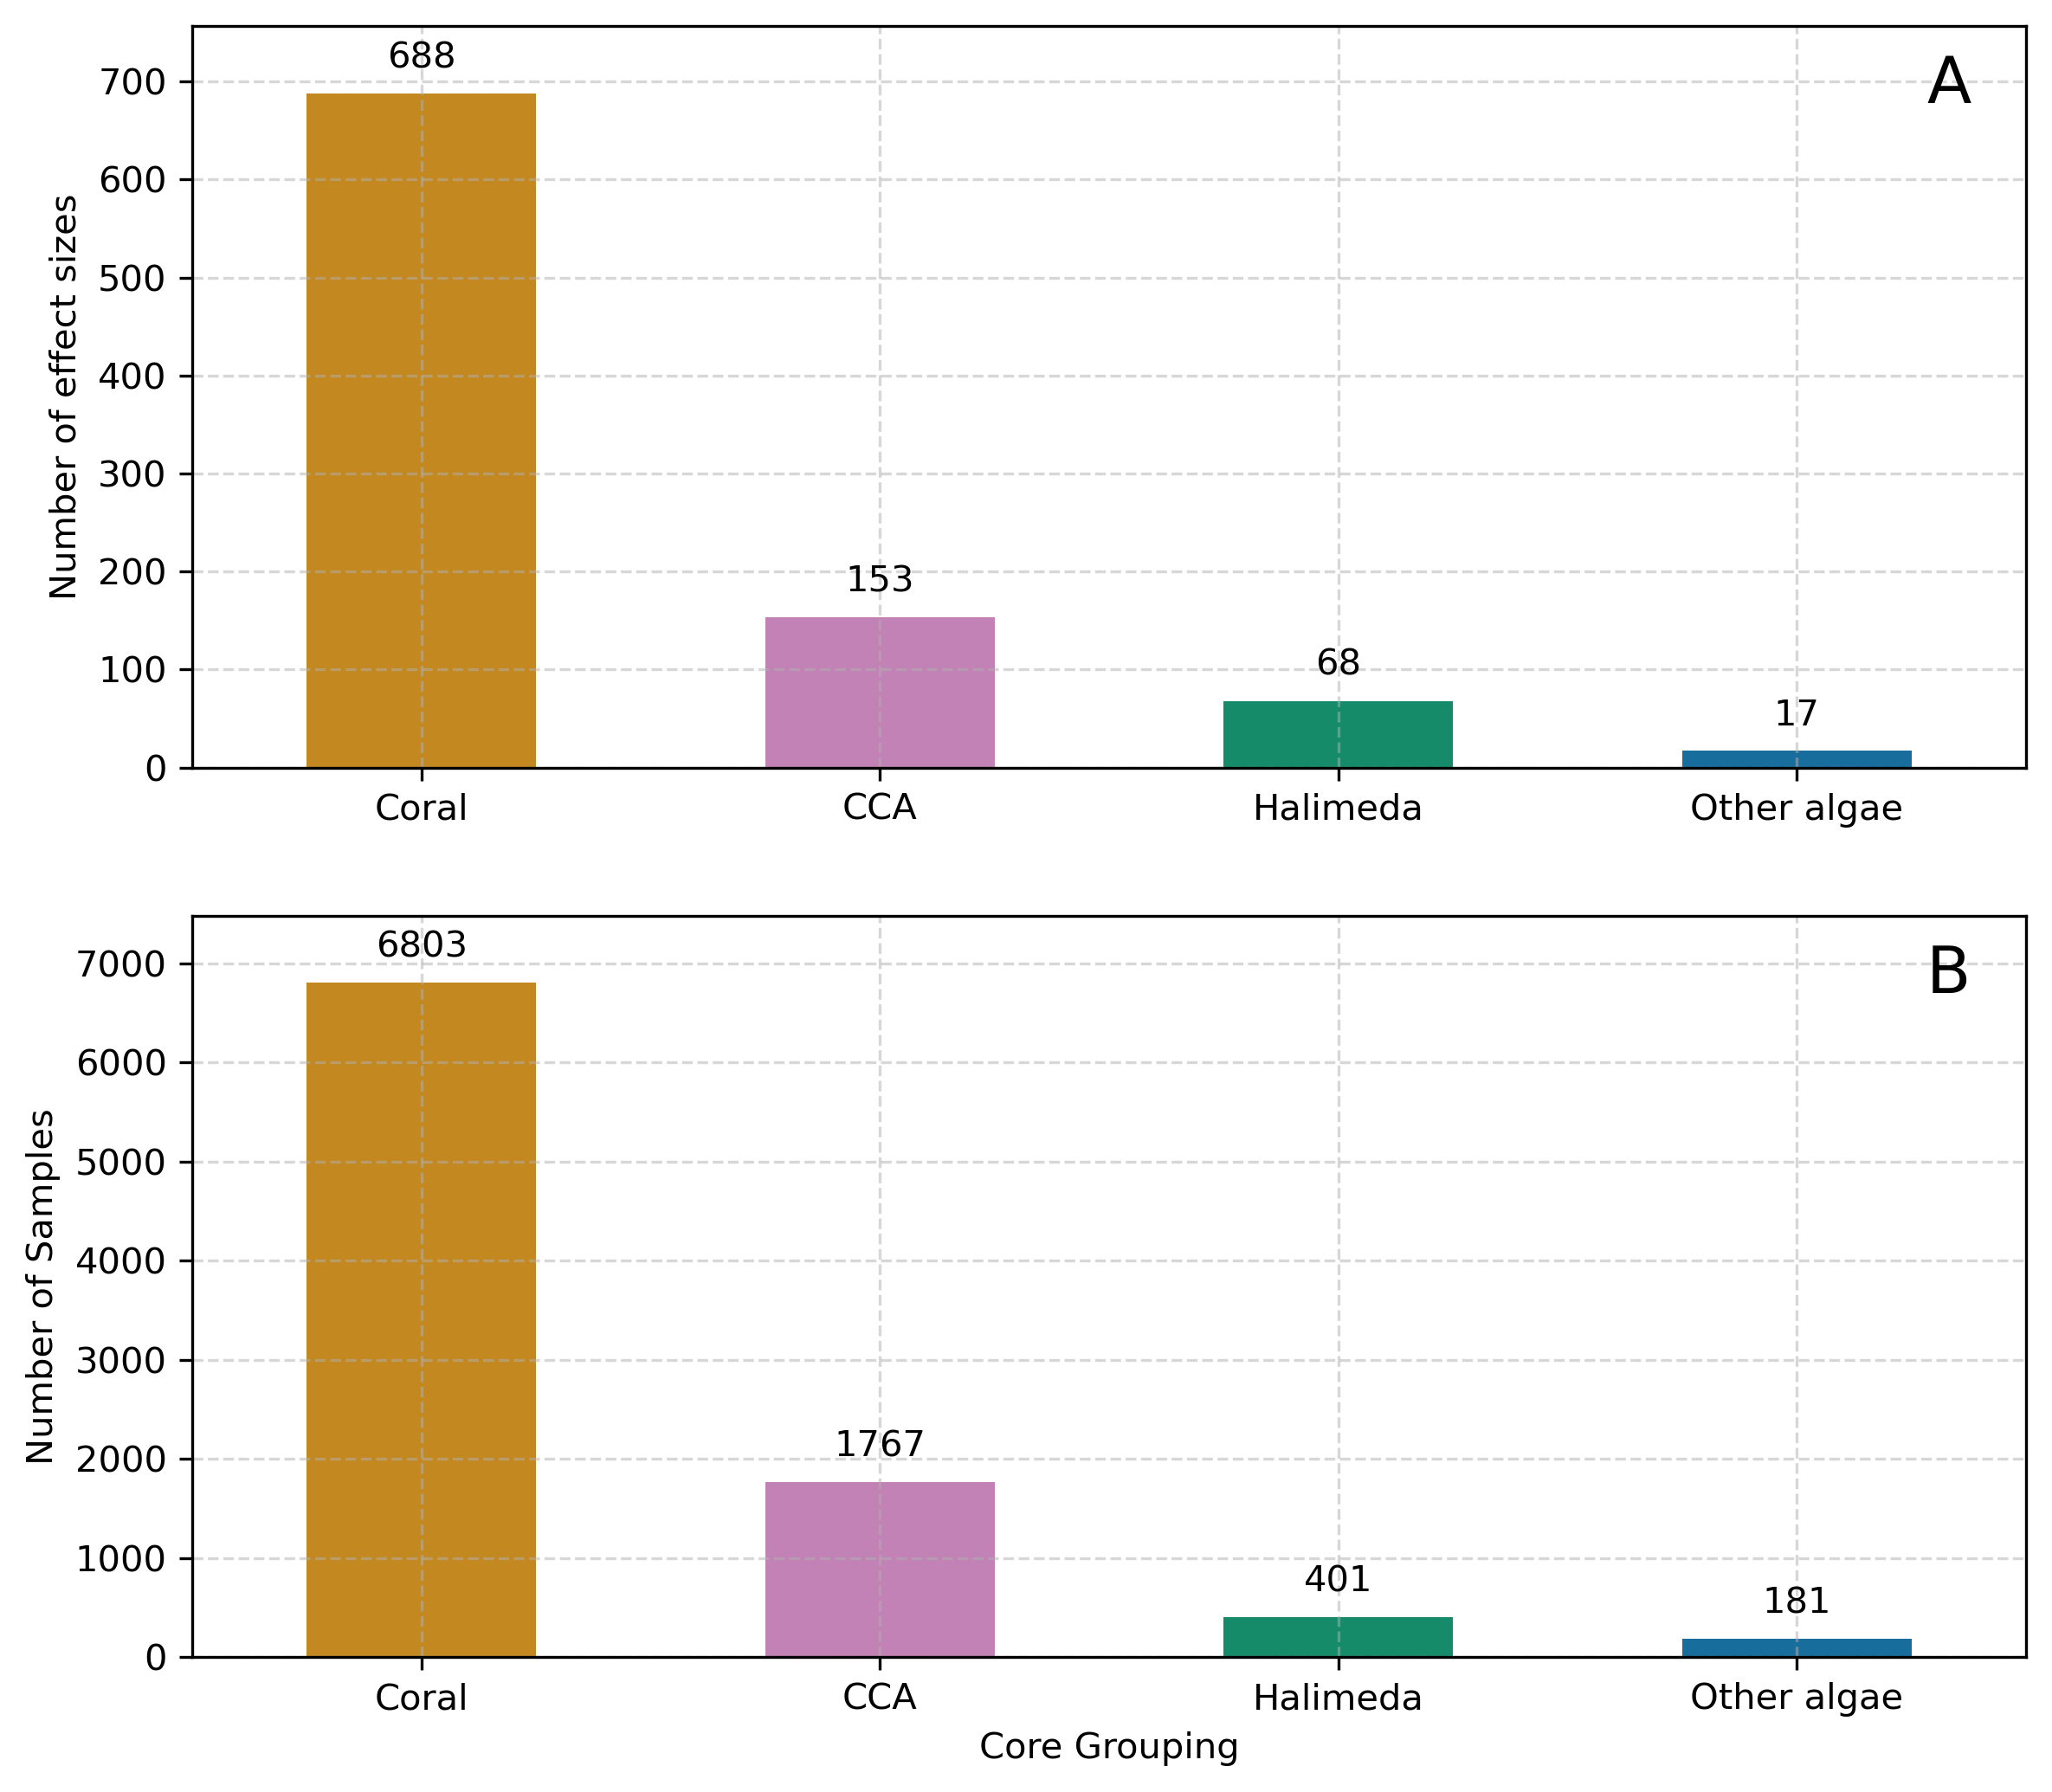

In [99]:
fig, ax = data_exploration.plot_effect_sizes_summary(
    calcification_clim_filtered_data_df
)
# plot_utils.save_fig(fig, "FIG_S3")

### Figure S4 – Distribution of effect sizes

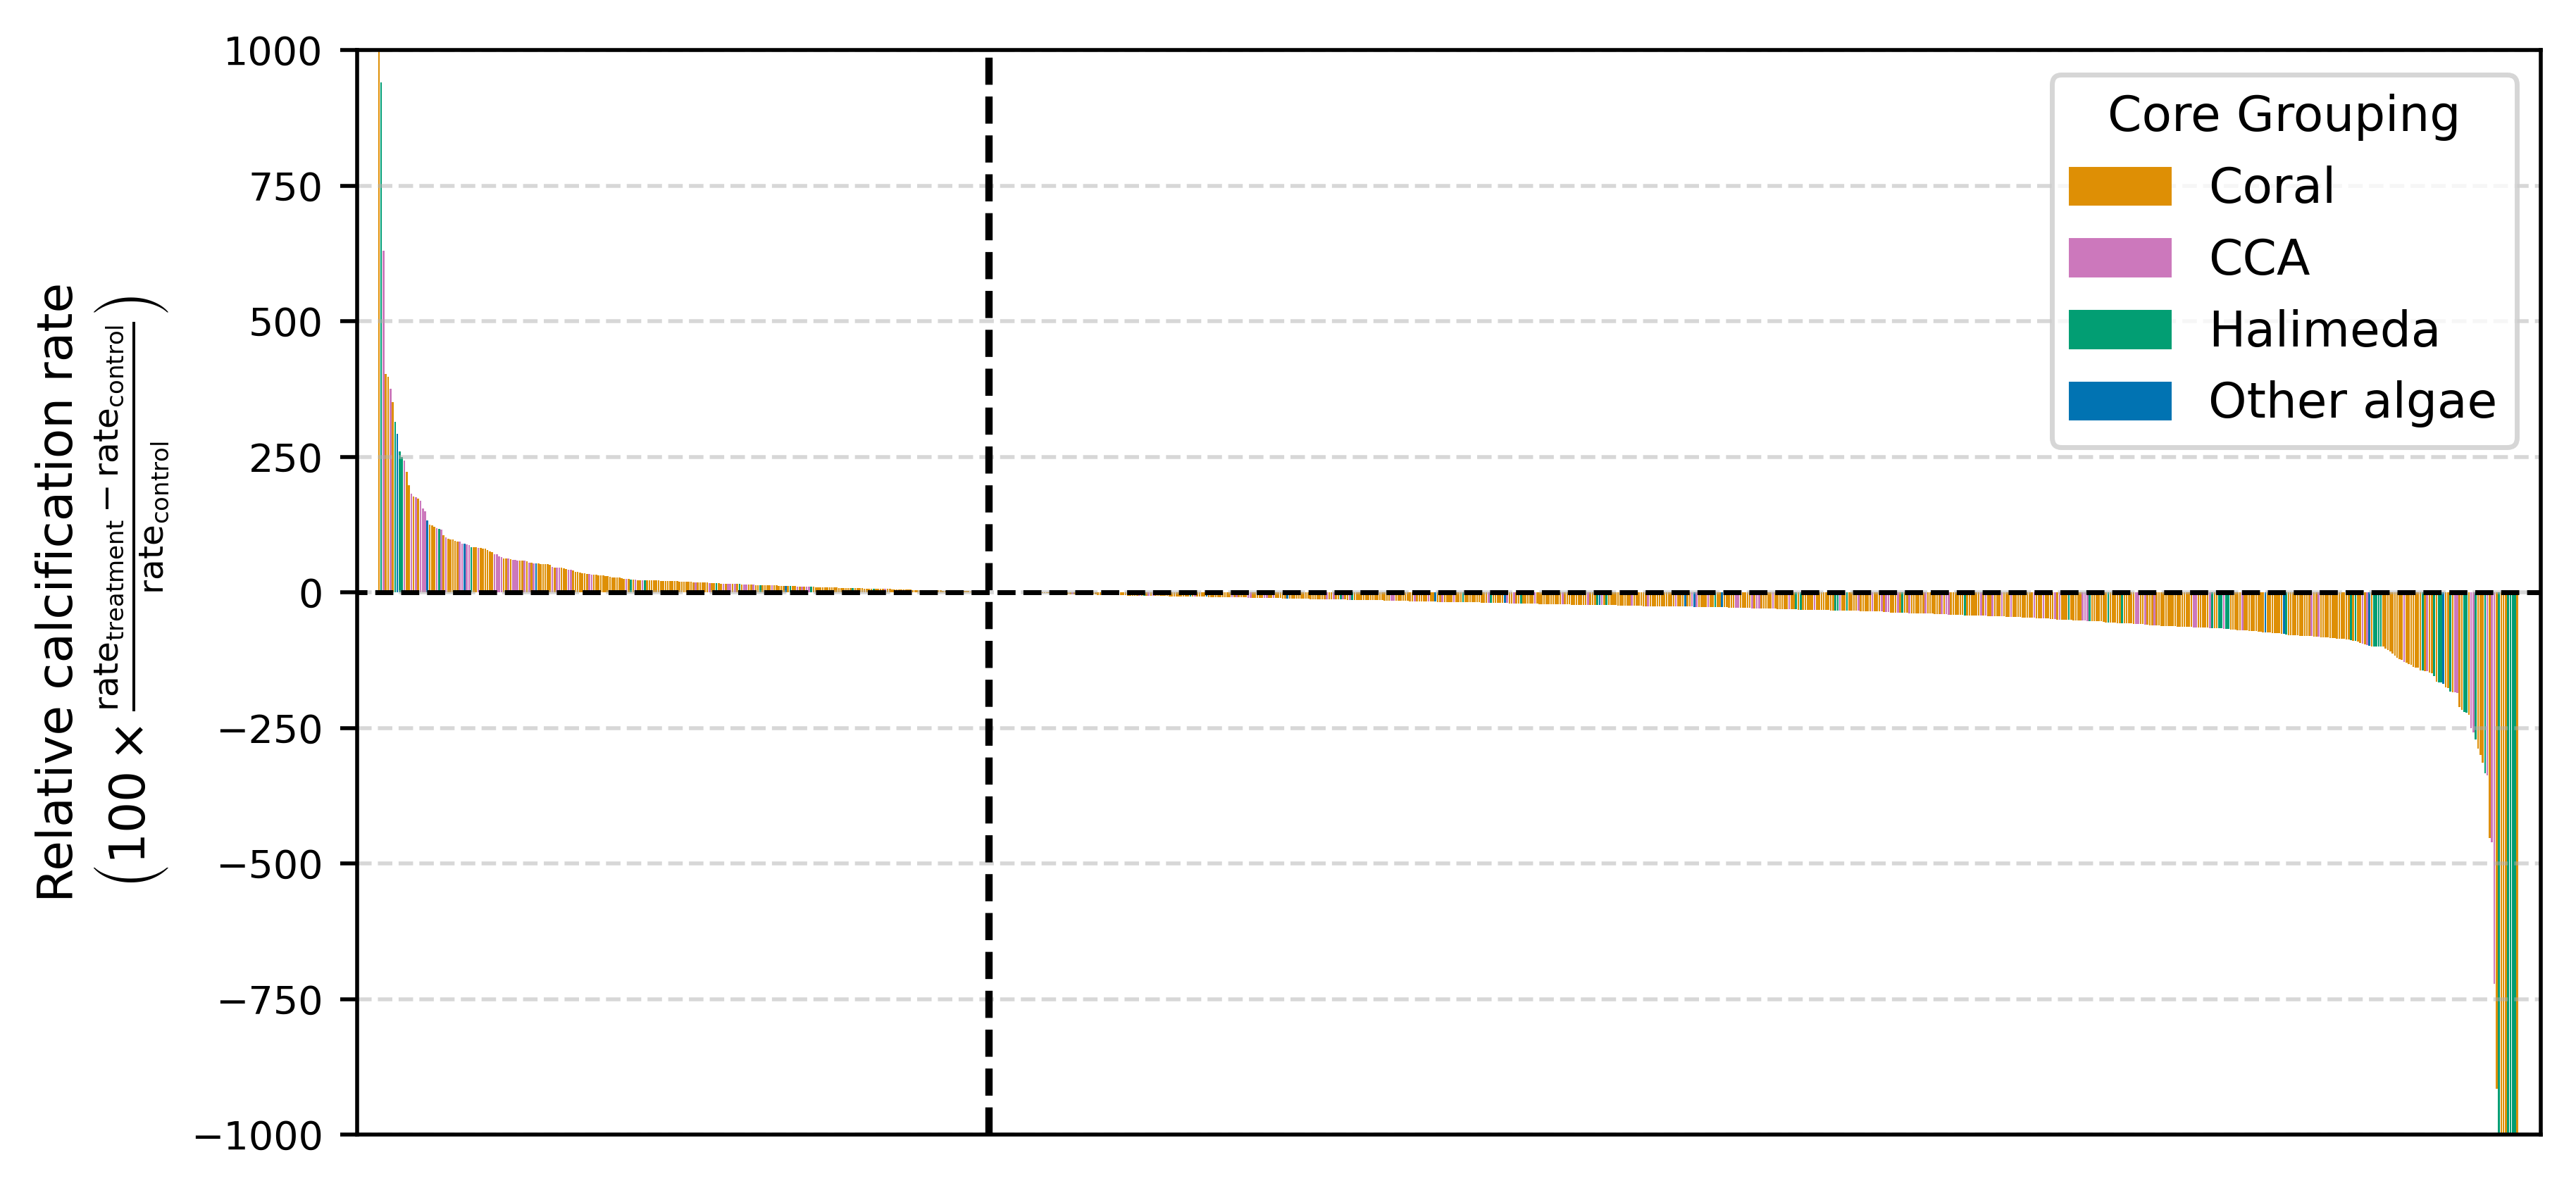

In [100]:
fig, ax = data_exploration.plot_ordered_effect_size_bar(
    calcification_clim_filtered_data_df
)
# plot_utils.save_fig(fig, "FIG_S4")

### Figure S5 – Distributions of effect sizes

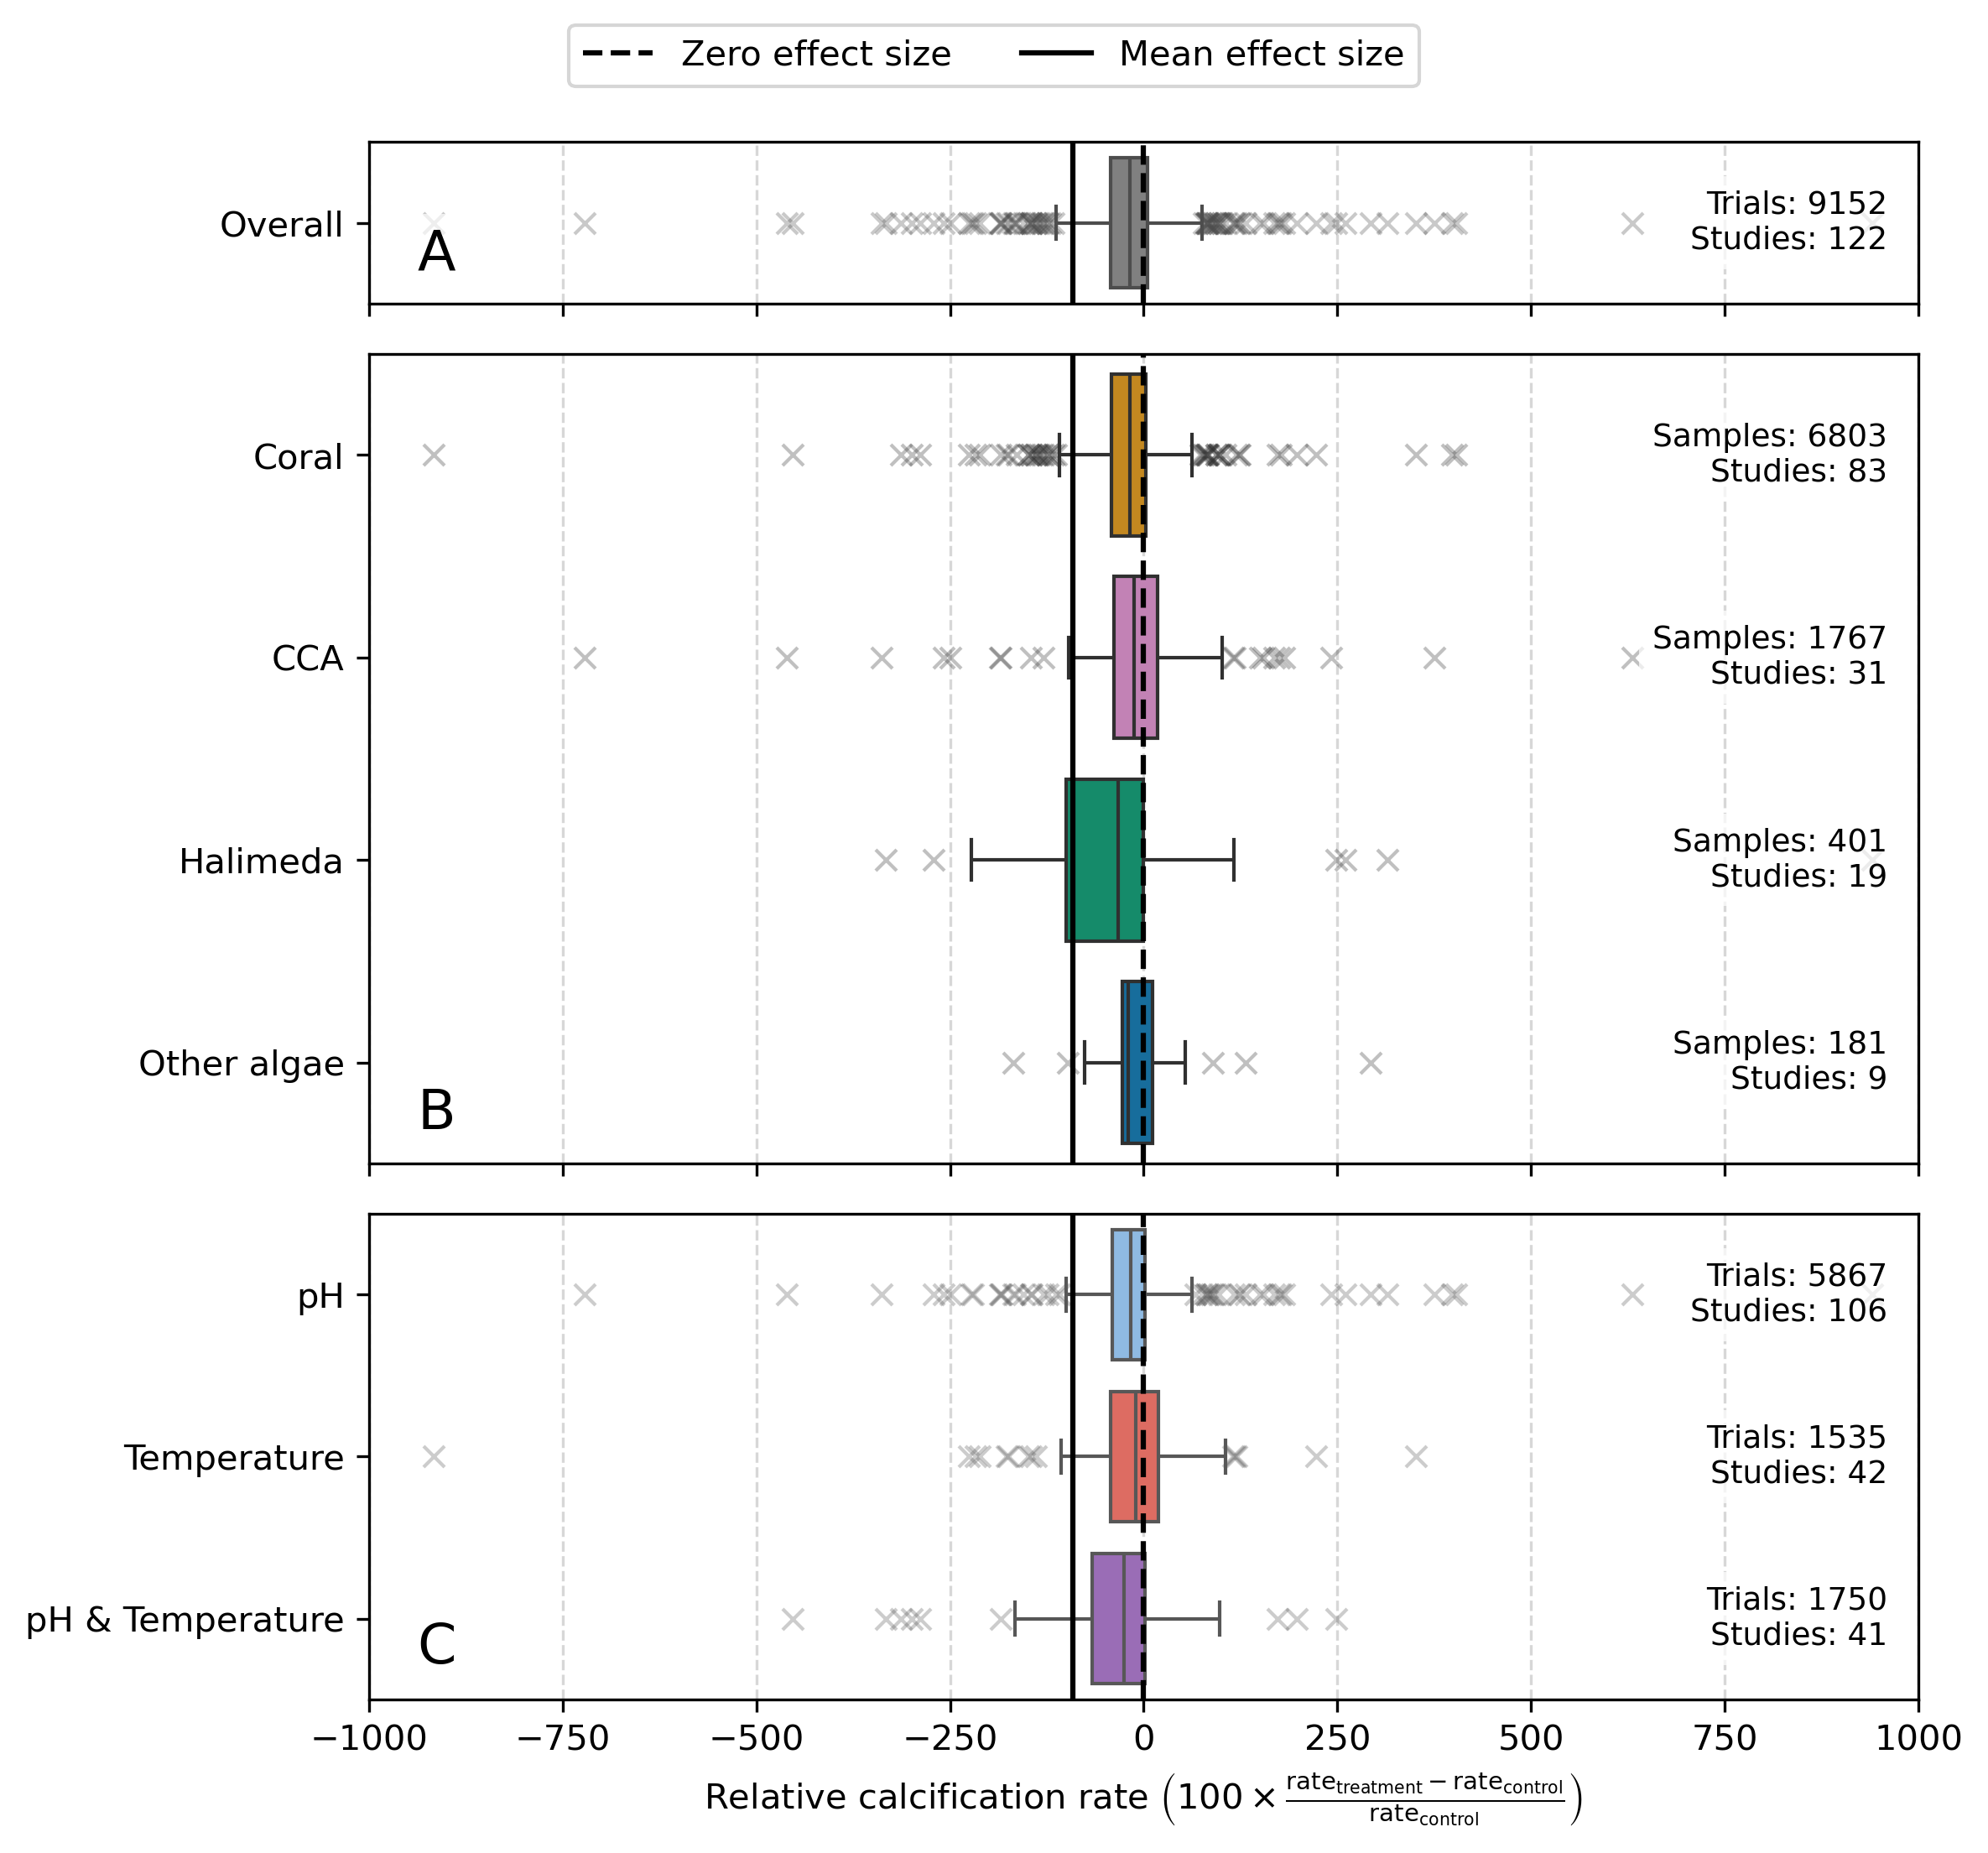

In [101]:
fig, ax = data_exploration.plot_boxplots_by_groupings(
    calcification_clim_filtered_data_df
)
# plot_utils.save_fig(fig, "FIG_S5")

In [102]:
print("Mean effect size:", calcification_clim_filtered_data_df[EFFECT_TYPE].mean())
print("Median effect size:", calcification_clim_filtered_data_df[EFFECT_TYPE].median())
num_multivariate_studies = calcification_clim_filtered_data_df.loc[
    calcification_clim_filtered_data_df.treatment == "temp_phtot",
    "original_doi",
].nunique()
print(
    f"Number of studies varying pH and temperature simultaneously: {num_multivariate_studies} ({num_multivariate_studies / calcification_clim_filtered_data_df.original_doi.nunique():.0%})"
)
print(
    f"Number of multivariate samples: {calcification_clim_filtered_data_df[calcification_clim_filtered_data_df.treatment == 'temp_phtot'].shape[0]} ({calcification_clim_filtered_data_df[calcification_clim_filtered_data_df.treatment == 'temp_phtot'].shape[0] / calcification_clim_filtered_data_df.shape[0]:.0%})"
)
print(
    f"Median sample duration: {calcification_clim_filtered_data_df.duration.median()} days"
)

Mean effect size: -91.30587013196173
Median effect size: -17.906809430244714
Number of studies varying pH and temperature simultaneously: 41 (34%)
Number of multivariate samples: 177 (19%)
Median sample duration: 42.0 days


## Sensitivity Analyses

### Figure S6 – Sensitivity analysis of extreme effect sizes (by magnitude, variance)

This analysis was run natively in R: see `line 84` of `calcification_meta_analysis/analysis/rnative/analysis.R`

### Figure S7 – Sensitivity analysis of extreme effect sizes (by Cook's distance)

This analysis was run natively in R: see `line 90` of `calcification_meta_analysis/analysis/rnative/analysis.R`

## Publication bias

### Figure S8 – Assessing publication bias via statistical tests and a funnel plot

This analysis was run natively in R: see `line 96` of `calcification_meta_analysis/analysis/rnative/analysis.R`

## Results

In [103]:
# linear additive model
metafor_model = metafor.MetaforModel(
    calcification_clim_filtered_data_df,
    effect_type=EFFECT_TYPE,
    treatment=["phtot", "temp", "temp_phtot"],
    formula=f"{EFFECT_TYPE} ~ delta_ph + delta_t - 1",
    cooks_distance_type=None,
).fit_model()

# display model results
metafor_model.view_model_summary()


INFO:calcification_meta_analysis.analysis.metafor:R DataFrame created with 926 rows
INFO:calcification_meta_analysis.analysis.metafor:Metafor initialized successfully
INFO:calcification_meta_analysis.analysis.metafor:Formula: st_relative_calcification ~ delta_ph + delta_t - 1
INFO:calcification_meta_analysis.analysis.metafor:Treatment: ['phtot', 'temp', 'temp_phtot']
INFO:calcification_meta_analysis.analysis.metafor:Data shape: (926, 89)
INFO:calcification_meta_analysis.analysis.metafor:Fitting model with formula: st_relative_calcification ~ delta_ph + delta_t - 1



----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'temp_phtot']
Total samples in input data:  926
Total samples of relevant investigation:  926
Total samples dropped due to OLS Cook's distance:  0
Dropped due to NaN values:  0
Dropped due to Cook's distance:  0
Final sample count: 926 (0 rows dropped)



  
  
  
  
INFO:calcification_meta_analysis.analysis.metafor:Extracted model components: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']
INFO:calcification_meta_analysis.analysis.metafor:Model fitted successfully
INFO:calcification_meta_analysis.analysis.metafor:Components extracted: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']



Multivariate Meta-Analysis Model (k = 926; method: REML)

    logLik    Deviance         AIC         BIC        AICc   
-4908.8593   9817.7186   9825.7186   9845.0334   9825.7621   

Variance Components:

              estim     sqrt  nlvls  fixed  factor 
sigma^2.1  540.4842  23.2483    141     no     doi 
sigma^2.2  779.3100  27.9161    926     no  doi/ID 

Test for Residual Heterogeneity:
QE(df = 924) = 15018.2456, p-val < .0001

Test of Moderators (coefficients 1:2):
QM(df = 2) = 107.1876, p-val < .0001

Model Results:

          estimate      se     zval    pval    ci.lb    ci.ub      
delta_ph   65.4346  7.6547   8.5483  <.0001  50.4317  80.4374  *** 
delta_t    -6.1356  1.0766  -5.6992  <.0001  -8.2457  -4.0256  *** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




###  Testing random effect structure

In [104]:
print("Fitting model with ~ 1 | DOI random effect structure...")
doi_model = metafor.MetaforModel(
    calcification_clim_filtered_data_df,
    effect_type=EFFECT_TYPE,
    formula=f"{EFFECT_TYPE} ~ delta_ph + delta_t - 1",
    random="~ 1 | doi",
    verbose=False,
    cooks_distance_type=None,
).fit_model()
print("\nFitting model with ~ 1 | DOI/ID random effect structure...")
doi_id_model = metafor.MetaforModel(
    calcification_clim_filtered_data_df,
    effect_type=EFFECT_TYPE,
    formula=f"{EFFECT_TYPE} ~ delta_ph + delta_t - 1",
    random="~ 1 | doi/ID",
    verbose=False,
    cooks_distance_type=None,
).fit_model()

Fitting model with ~ 1 | DOI random effect structure...



Fitting model with ~ 1 | DOI/ID random effect structure...


In [105]:
print("~1 | DOI random effect structure:")
print(doi_model.generate_model_fit_dataframe())
print(
    f"Between-study heterogeneity: {float(doi_model.get_heterogeneity_dataframe()['sigma2.1'].values[0]):.02f}"
)
print("\n~1 | DOI/ID random effect structure:")
print(doi_id_model.generate_model_fit_dataframe())
print(
    f"Between-study heterogeneity: {float(doi_id_model.get_heterogeneity_dataframe()['sigma2.1'].values[0]):.02f}"
)
print(
    f"Within-study heterogeneity: {float(doi_id_model.get_heterogeneity_dataframe()['sigma2.2'].values[0]):.02f}"
)
print(
    f"Proportion of variance due to between-study heterogeneity: {float(doi_id_model.get_heterogeneity_dataframe()['sigma2.1'].values[0]) / (float(doi_id_model.get_heterogeneity_dataframe()['sigma2.1'].values[0]) + float(doi_id_model.get_heterogeneity_dataframe()['sigma2.2'].values[0])):.02f}"
)

~1 | DOI random effect structure:
     k       LogLik      Deviance           AIC          AICc           BIC
0  926 -7015.930811  14031.861622  14037.861622  14037.887709  14052.347758
Between-study heterogeneity: 1015.64

~1 | DOI/ID random effect structure:
     k       LogLik     Deviance          AIC         AICc          BIC
0  926 -4908.859295  9817.718591  9825.718591  9825.762116  9845.033439
Between-study heterogeneity: 540.48
Within-study heterogeneity: 779.31
Proportion of variance due to between-study heterogeneity: 0.41


### Example predicted response surface

INFO:calcification_meta_analysis.analysis.metafor:R DataFrame created with 688 rows
INFO:calcification_meta_analysis.analysis.metafor:Metafor initialized successfully
INFO:calcification_meta_analysis.analysis.metafor:Formula: st_relative_calcification ~ delta_ph + delta_t - 1
INFO:calcification_meta_analysis.analysis.metafor:Treatment: ['phtot', 'temp', 'temp_phtot']
INFO:calcification_meta_analysis.analysis.metafor:Data shape: (688, 89)
INFO:calcification_meta_analysis.analysis.metafor:Fitting model with formula: st_relative_calcification ~ delta_ph + delta_t - 1



----- PROCESSING SUMMARY -----
Treatment:  ['phtot', 'temp', 'temp_phtot']
Total samples in input data:  688
Total samples of relevant investigation:  688
Total samples dropped due to OLS Cook's distance:  0
Dropped due to NaN values:  0
Dropped due to Cook's distance:  0
Final sample count: 688 (0 rows dropped)



  
  
  
INFO:calcification_meta_analysis.analysis.metafor:Extracted model components: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']
INFO:calcification_meta_analysis.analysis.metafor:Model fitted successfully
INFO:calcification_meta_analysis.analysis.metafor:Components extracted: ['method', 'k', 'QE', 'QEp', 'QM', 'QMp', 'pval', 'beta', 'se', 'zval', 'ci.lb', 'ci.ub', 'fit.stats', 'sigma2.1', 'sigma2.2', 'sigma2']


(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='delta_ph', ylabel='delta_t'>)

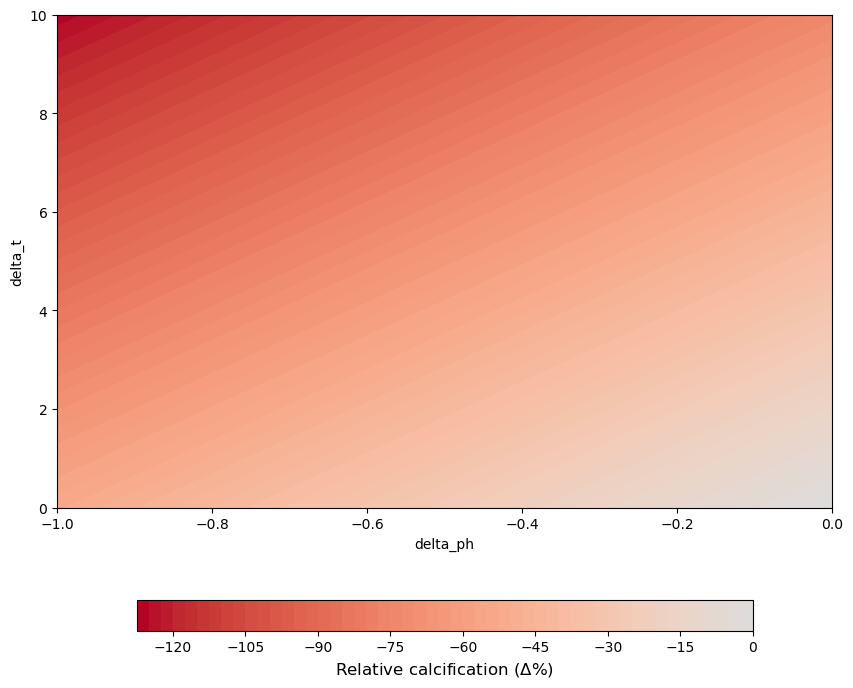

In [106]:
# select and visualise example core grouping
coral_model = metafor.MetaforModel(
    calcification_clim_filtered_data_df[
        calcification_clim_filtered_data_df["core_grouping"] == "Coral"
    ],
    effect_type=EFFECT_TYPE,
    treatment=["phtot", "temp", "temp_phtot"],
    formula=f"{EFFECT_TYPE} ~ delta_ph + delta_t - 1",
    cooks_distance_type=None,
).fit_model()

analysis_plot.plot_model_surface_2d(
    model=coral_model,
    moderator_names=["delta_ph", "delta_t"],
    prediction_limits={"delta_ph": (-1, 0), "delta_t": (0, 10)},
)

### Generating future predictions

Using forecasted global climatology anomalies to sample from predicted response surfaces. 



In [107]:
# --- process bioerosion data --- #
extracted_bioerosion_data_fp = config.data_dir / "extracted_bioerosion_data.xlsx"
bioerosion_data_df = process.process_extracted_calcification_data(
    extracted_bioerosion_data_fp,
    "all_data",
    save_name="analysis_ready_bioerosion_data.csv",
)
bioerosion_data_df["core_grouping"] = "Bioerosion"

INFO:calcification_meta_analysis.processing.locations:Using cached locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/resources/gmaps_locations.yaml
INFO:calcification_meta_analysis.processing.locations:Dropped 0 row(s) for which latitude or longitude is NaN
INFO:calcification_meta_analysis.processing.taxonomy:Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/resources/species_mapping.yaml
INFO:calcification_meta_analysis.processing.cleaning:Unit standardization complete: 81/81 rows converted successfully
INFO:calcification_meta_analysis.processing.carbonate_processing:Loading measured values...
INFO:calcification_meta_analysis.processing.carbonate_processing:Calculated 13 missing pHt value(s) using pHnbs/pHsws
INFO:calcification_meta_analysis.processing.carbonate_

Calculating carbonate chemistry:   0%|          | 0/81 [00:00<?, ?it/s]

INFO:calcification_meta_analysis.processing.carbonate_processing:Filled 159.0 NaN values by combining dataframes


Total number of samples: 4063.0


Assigning treatment groups:   0%|          | 0/17 [00:00<?, ?it/s]

Removing 0 rows with n=1


  0%|          | 0/16 [00:00<?, ?it/s]

Saved to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/data/analysis_ready_bioerosion_data.csv


In [108]:
# generate the calcification meta-data
print("Number of unique studies:", bioerosion_data_df.original_doi.nunique())
print(
    "Number of unique sampling locations:",
    len(bioerosion_data_df.groupby(["latitude", "longitude"])),
)

Number of unique studies: 13
Number of unique sampling locations: 9


In [109]:
# reverse sign of effect sizes (cohens_d, hedges_g, relative_calcification, absolute_calcification, st_relative_calcification, st_absolute_calcification) for plotting alongside calcification rates
bioerosion_data_df.loc[:, "cohens_d"] = -bioerosion_data_df["cohens_d"]
bioerosion_data_df.loc[:, "hedges_g"] = -bioerosion_data_df["hedges_g"]
bioerosion_data_df.loc[:, "relative_calcification"] = -bioerosion_data_df[
    "relative_calcification"
]
bioerosion_data_df.loc[:, "absolute_calcification"] = -bioerosion_data_df[
    "absolute_calcification"
]
bioerosion_data_df.loc[:, "st_relative_calcification"] = -bioerosion_data_df[
    "st_relative_calcification"
]
bioerosion_data_df.loc[:, "st_absolute_calcification"] = -bioerosion_data_df[
    "st_absolute_calcification"
]

-0.8617067196757783 4.725700984343634 -0.4454359177767929 0.017505629290729054


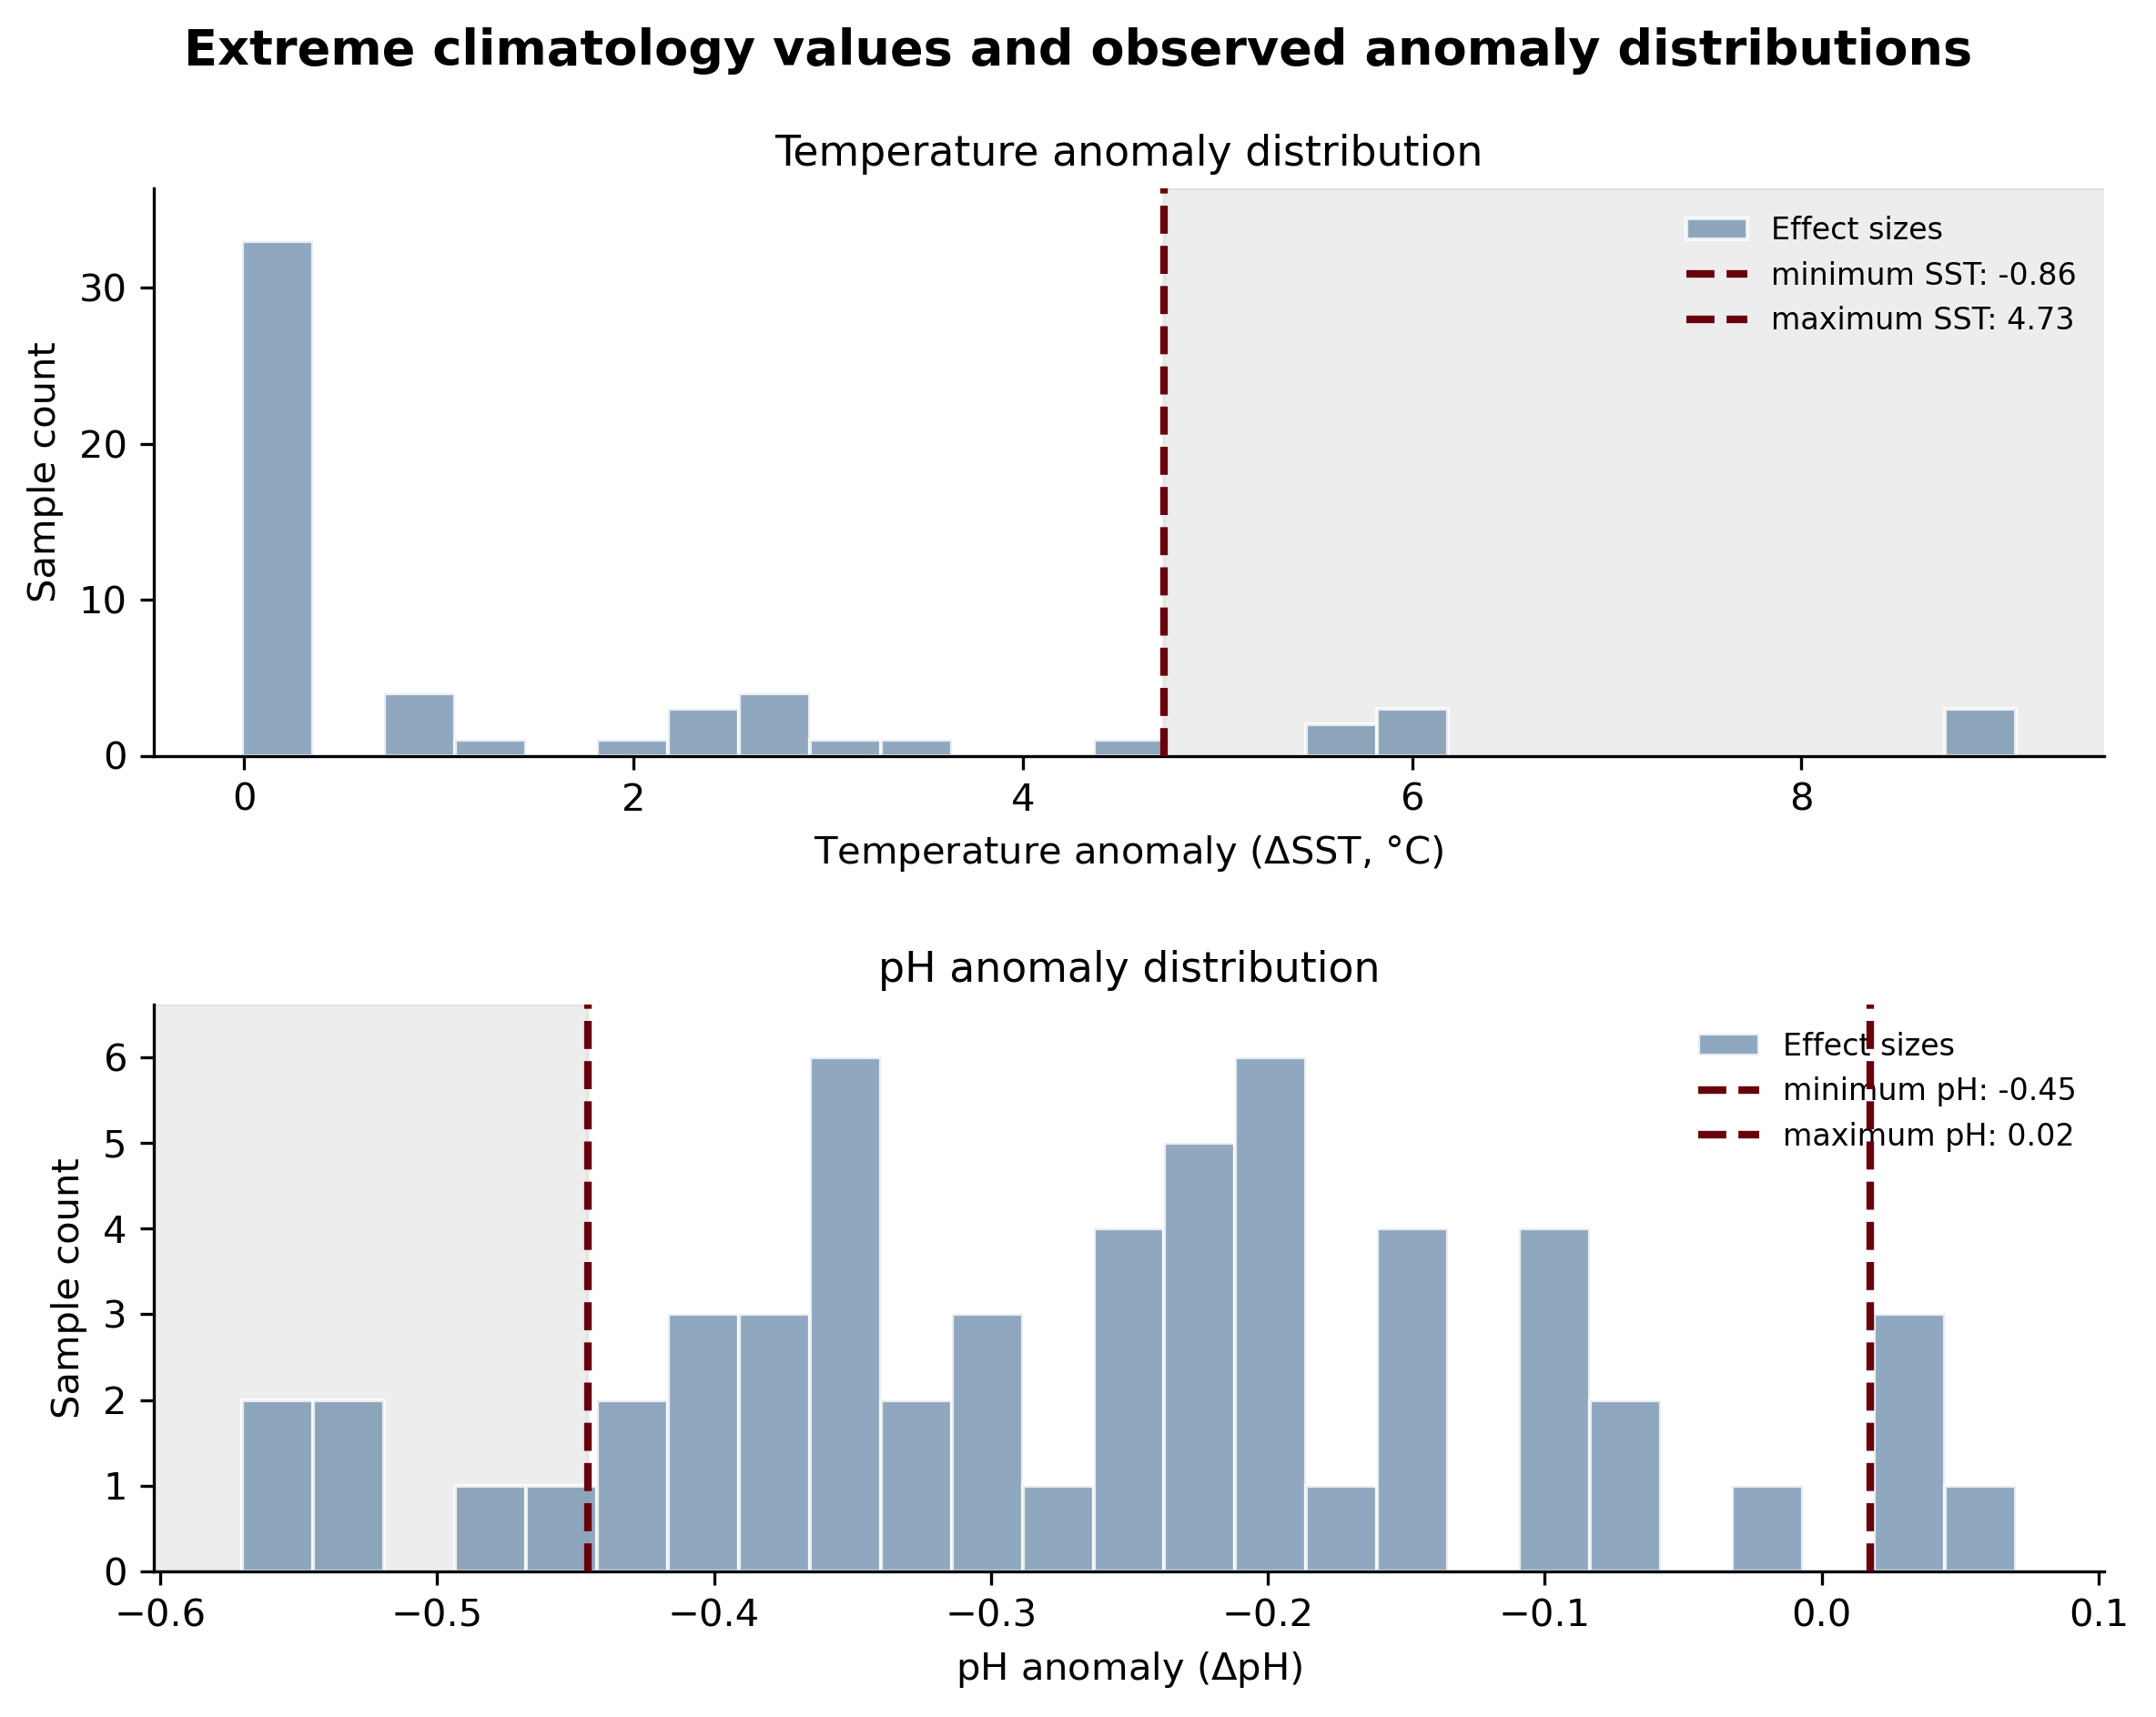

In [110]:
# filter for reasonable climatologies
bioerosion_clim_filtered_data_df = climatology.filter_df_by_extreme_climatologies(
    bioerosion_data_df, global_anomaly_df
)
climatology_plot.plot_extreme_climatology_values(bioerosion_data_df, global_anomaly_df);

In [ ]:
# calculate the predicted response surfaces for calcification and bioerosion with future climate conditions
combined_df = pd.concat(
    [calcification_clim_filtered_data_df, bioerosion_clim_filtered_data_df]
)

response_df, heterogeneity_df, models_dict = (
    analysis.construct_predicted_response_surfaces(
        combined_df,
        global_anomaly_df,
        EFFECT_TYPE,
        cooks_distance_type="native",
    )
)

In [111]:
# print example responses
df_ssp245_2100 = response_df.query(
    "scenario == 'ssp245' and time_frame == 2100 and percentile == 'mean'"
)
df_ssp585_2100 = response_df.query(
    "scenario == 'ssp585' and time_frame == 2100 and percentile == 'mean'"
)
mean_calcification_245 = df_ssp245_2100.query("core_grouping != 'Bioerosion'")[
    "pred"
].mean()
mean_calcification_585 = df_ssp585_2100.query("core_grouping != 'Bioerosion'")[
    "pred"
].mean()
mean_bioerosion_585 = df_ssp585_2100.query("core_grouping == 'Bioerosion'")[
    "pred"
].mean()
print(
    f"Mean predicted calcification response at 2100 under SSP 2-4.5: {mean_calcification_245:.1f}"
)
print(
    f"Mean predicted calcification response at 2100 under SSP 5-8.5: {mean_calcification_585:.1f}"
)
print(
    f"Mean predicted bioerosion response at 2100 under SSP 5-8.5: {mean_bioerosion_585:.1f}"
)

Mean predicted calcification response at 2100 under SSP 2-4.5: -23.2
Mean predicted calcification response at 2100 under SSP 5-8.5: -52.3
Mean predicted bioerosion response at 2100 under SSP 5-8.5: -150.7


### Figure S9 – Projected calcification and bioerosion rates in 2050 and 2100 under the Shared Socioeconomic Pathways (SSPs) relative to the historical baseline (1982-2011)

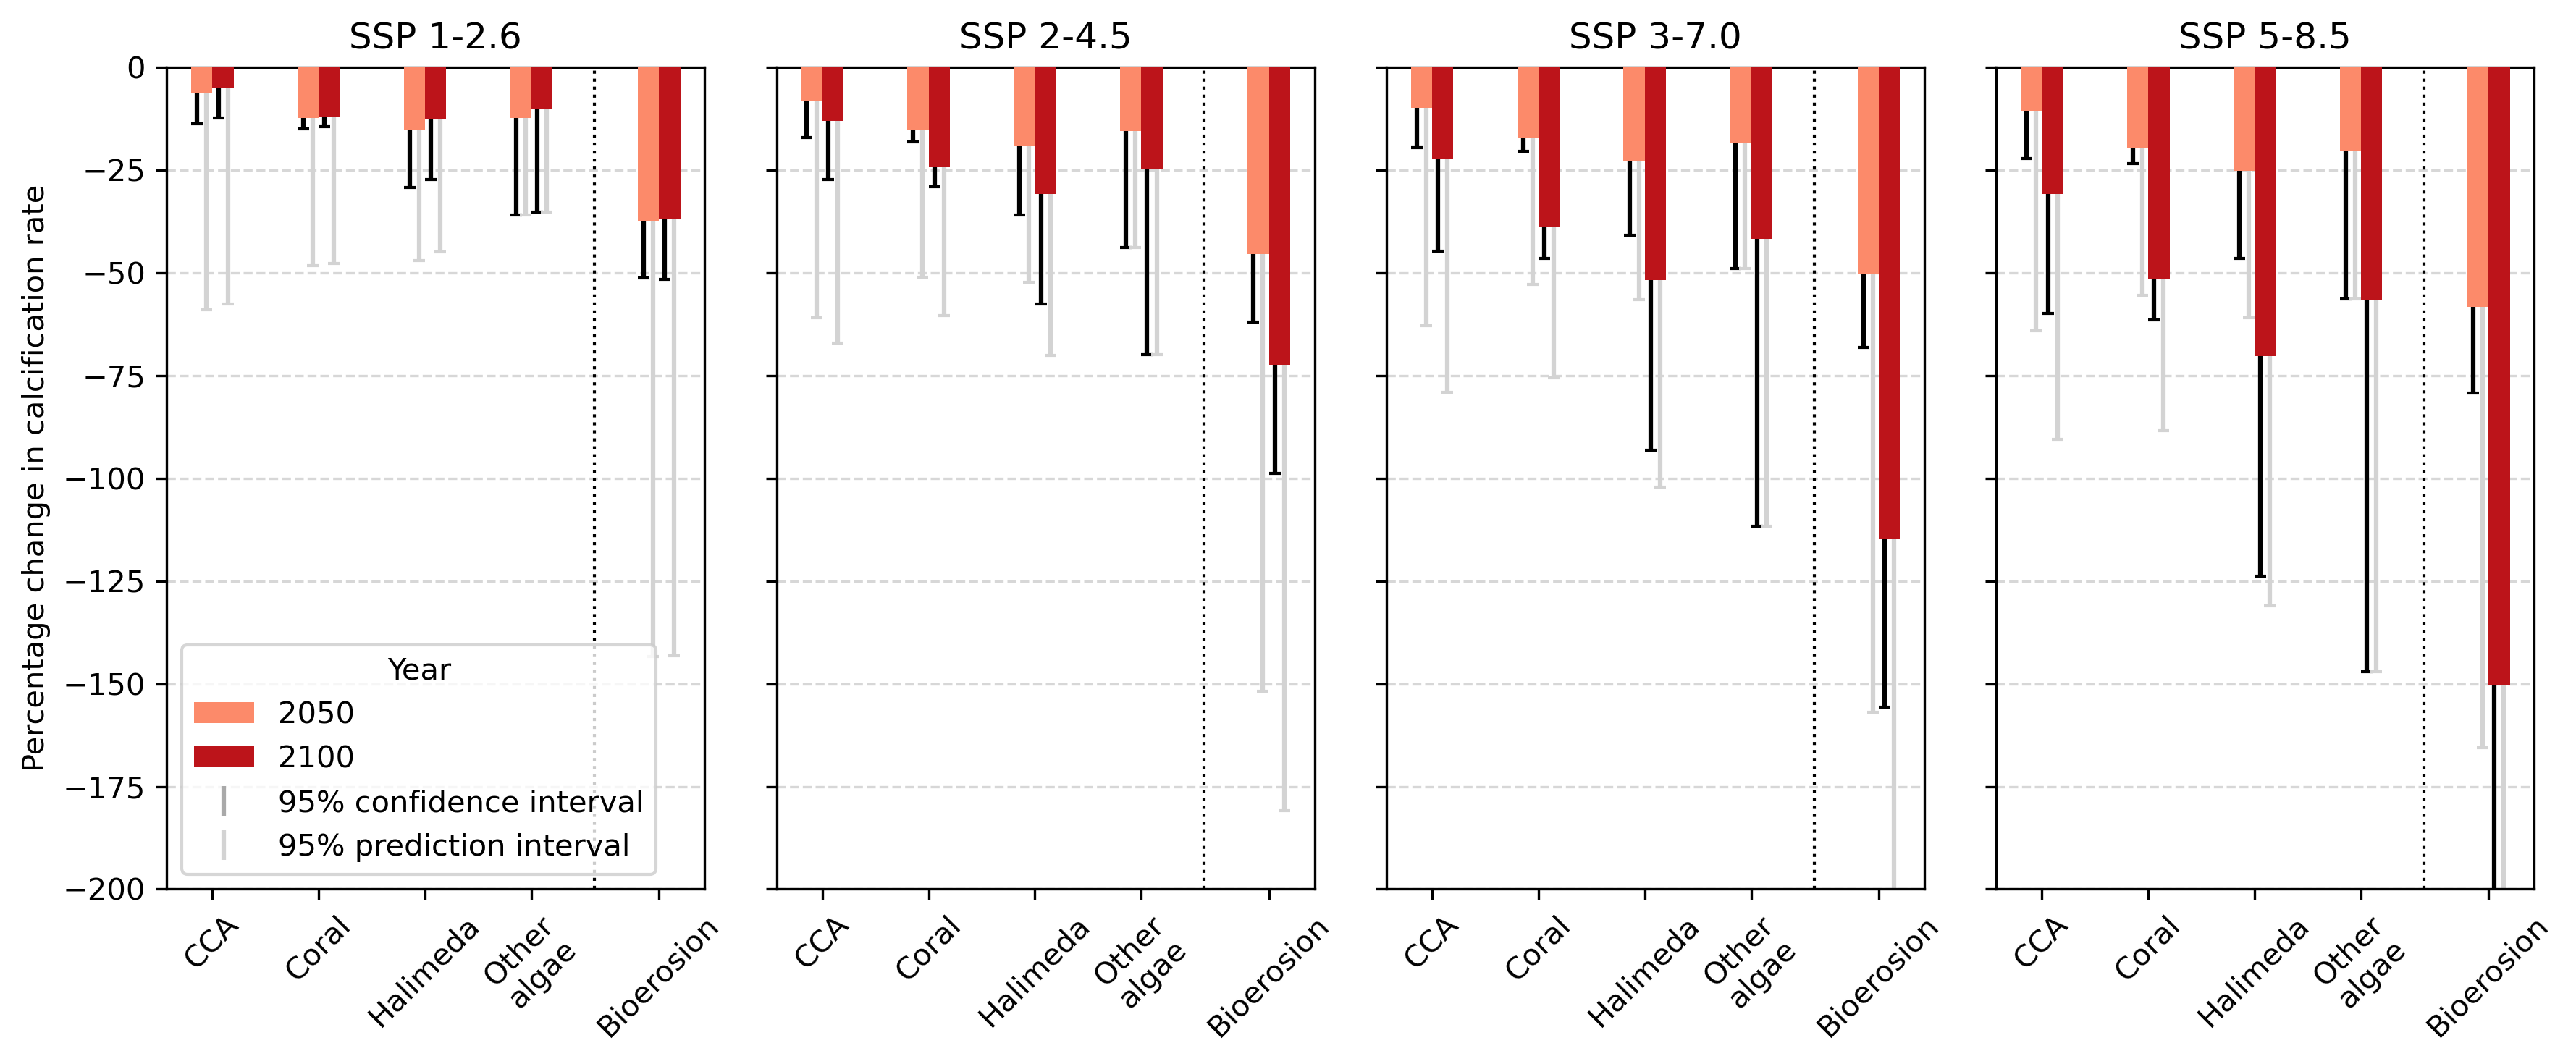

In [112]:
fig, ax = analysis_plot.plot_projected_rates_barplot(response_df)
# plot_utils.save_fig(fig, "FIG_S9")

In [113]:
print(
    f"CCA change in calcification rate by 2100 under SSP 5-8.5: {df_ssp585_2100[df_ssp585_2100.core_grouping == 'CCA'].pred.iloc[0]:.02f}"
)
print(
    f"Coral change in calcification rate by 2100 under SSP 5-8.5: {df_ssp585_2100[df_ssp585_2100.core_grouping == 'Coral'].pred.iloc[0]:.02f}"
)
print(
    f"Coral change in calcification rate by 2100 under SSP 2-4.5: {df_ssp245_2100[df_ssp245_2100.core_grouping == 'Coral'].pred.iloc[0]:.02f}"
)

CCA change in calcification rate by 2100 under SSP 5-8.5: -30.72
Coral change in calcification rate by 2100 under SSP 5-8.5: -51.49
Coral change in calcification rate by 2100 under SSP 2-4.5: -24.28


### Figure S10 – Projected calcification and bioerosion rates relative to the historical baseline (1982-2011) until the end of the century under the Shared Socioeconomic Pathways (SSPs)

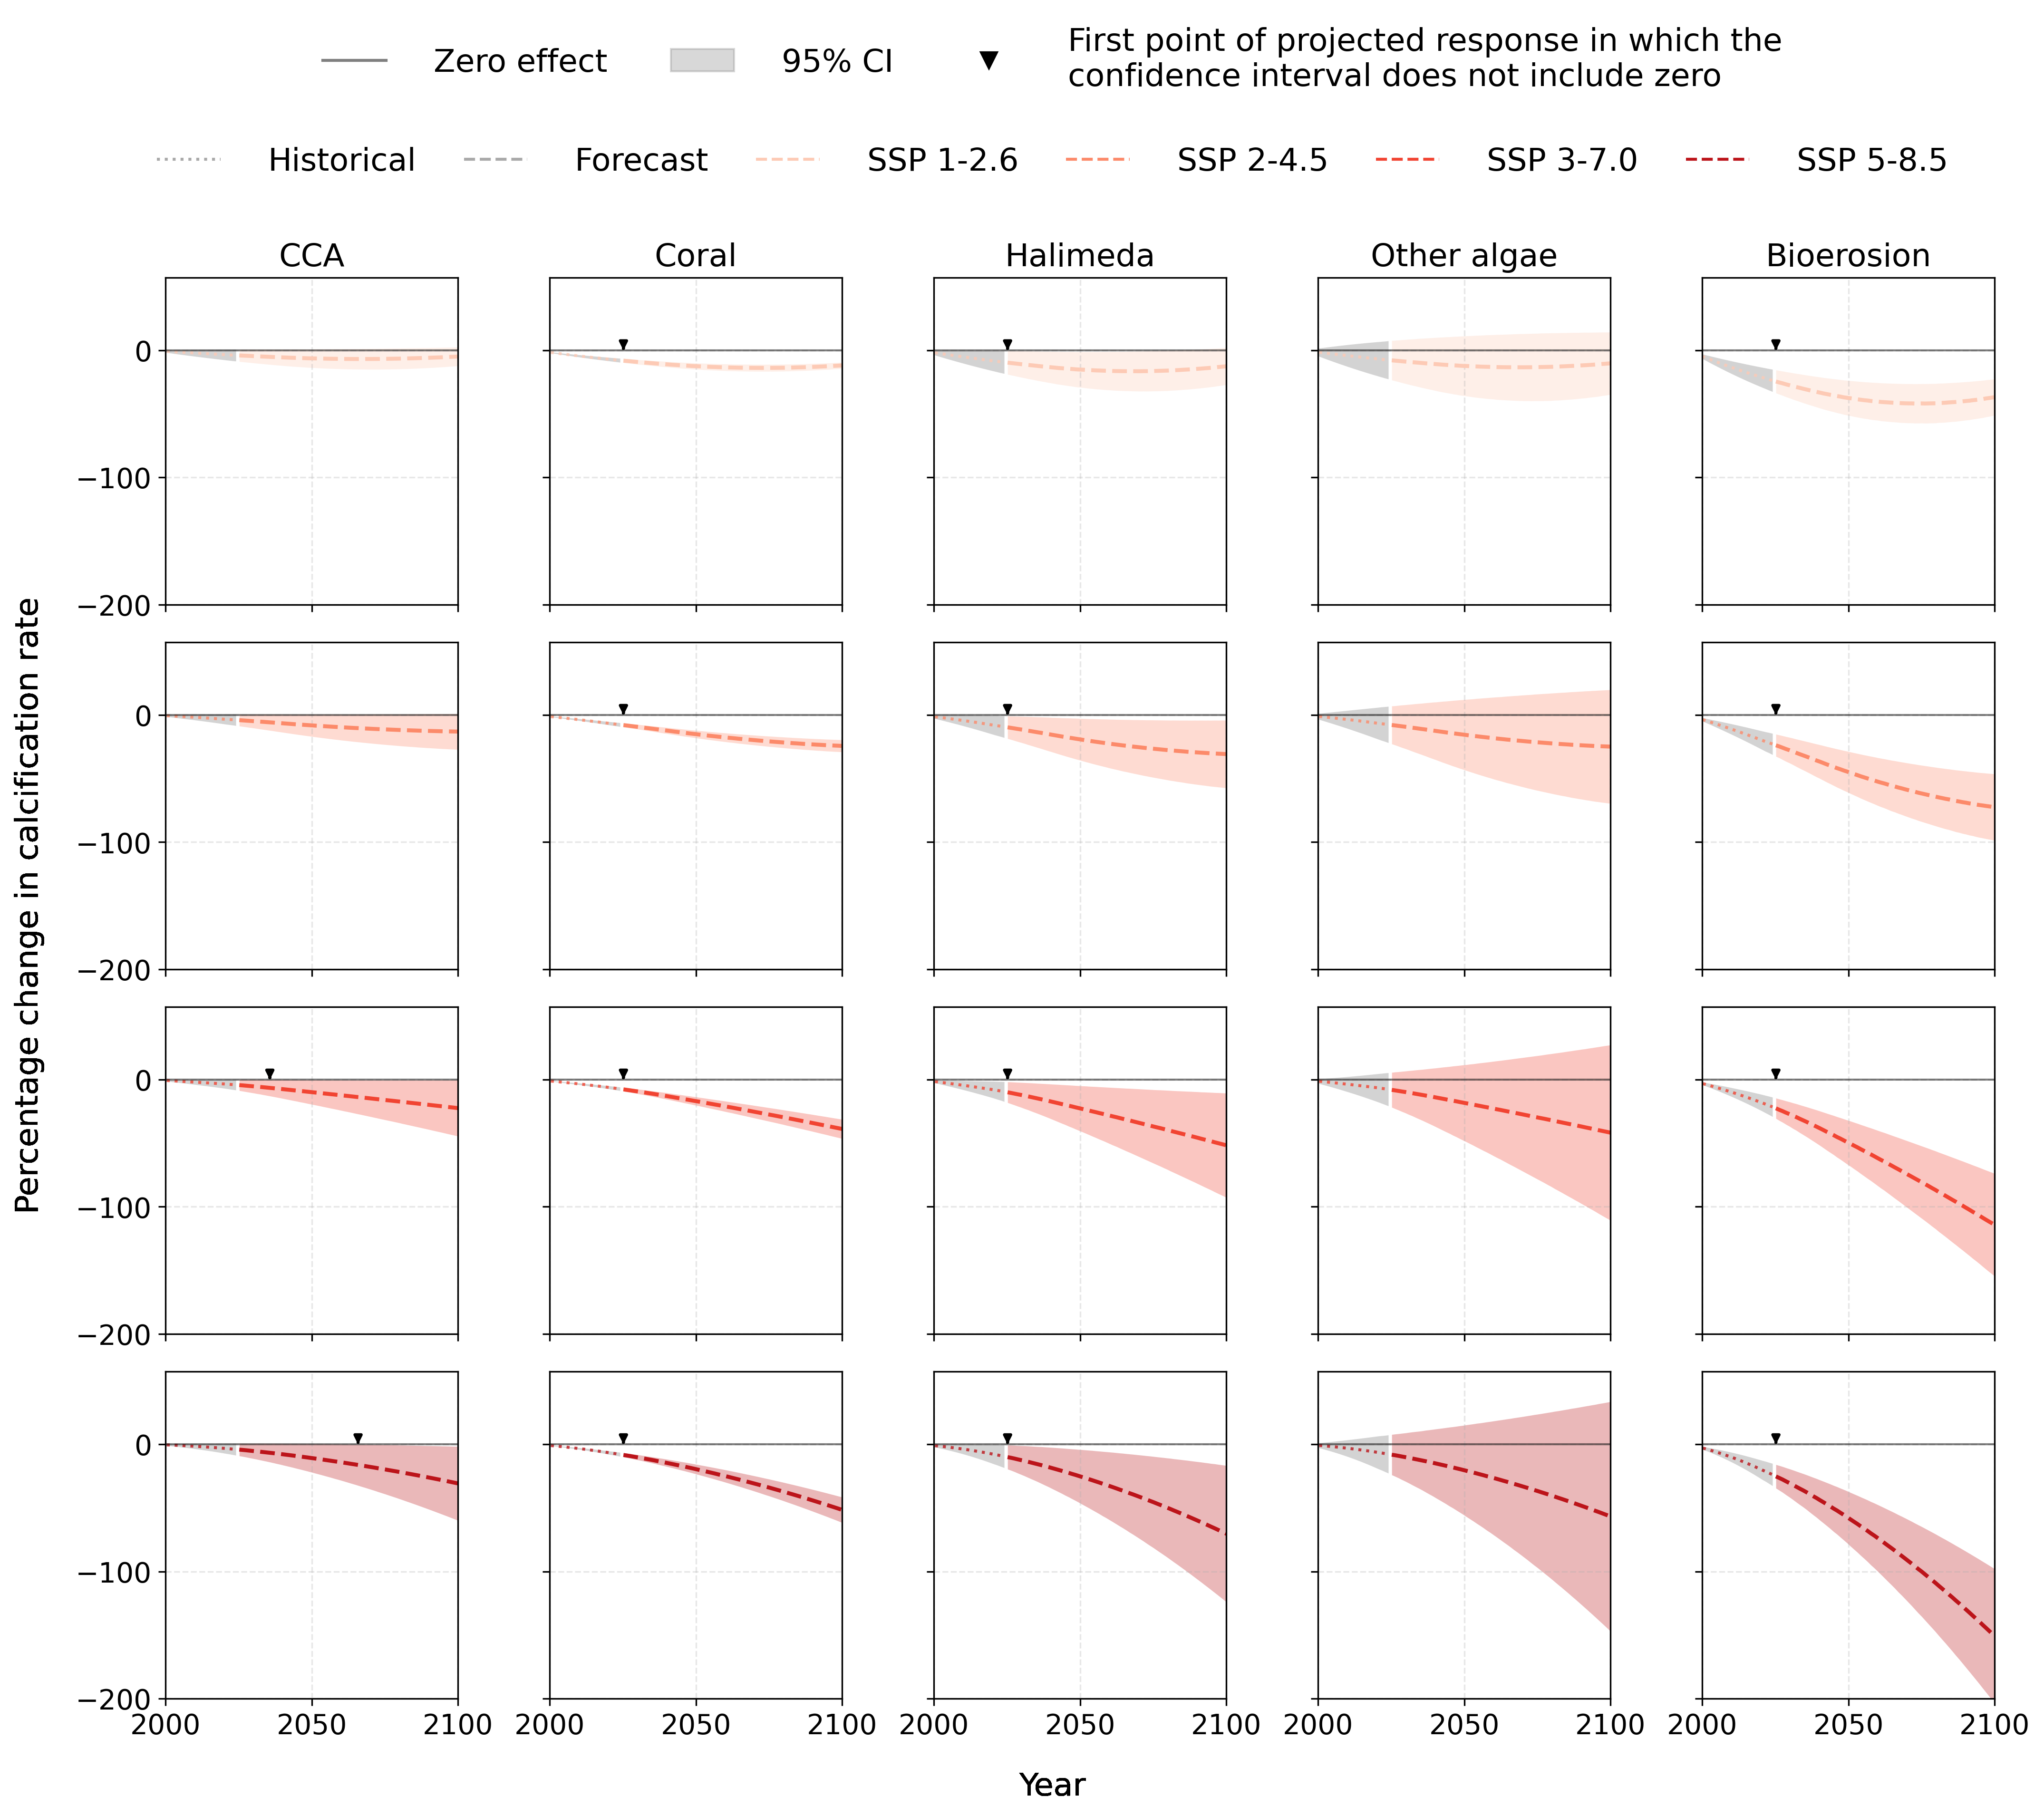

In [114]:
fig, ax = analysis_plot.plot_global_timeseries_grid(response_df, figsize=(14, 12))
# plot_utils.save_fig(fig, "FIG_S10")

In [115]:
# exploring heterogeneity for each core grouping
for cg in models_dict.keys():
    cg_model_info = models_dict[cg].model_dict
    print(cg.upper())
    print(
        f"QE test statistic: {cg_model_info['QE']:.05f} (p = {cg_model_info['QEp']:.05f})"
    )
    print(
        f"QM test statistic: {cg_model_info['QM']:.05f} (p = {cg_model_info['QMp']:.05f})"
    )
    print(f"Between-study variance: {cg_model_info['sigma2.1']:.05f}")
    print(f"Within-study variance: {cg_model_info['sigma2.2']:.05f}")

CORAL
QE test statistic: 10882.49605 (p = 0.00000)
QM test statistic: 102.56480 (p = 0.00000)
Between-study variance: 332.27596
Within-study variance: 580.00158
CCA
QE test statistic: 2276.44975 (p = 0.00000)
QM test statistic: 16.98654 (p = 0.00020)
Between-study variance: 707.13314
Within-study variance: 1040.39584
HALIMEDA
QE test statistic: 839.12320 (p = 0.00000)
QM test statistic: 25.79388 (p = 0.00000)
Between-study variance: 210.30836
Within-study variance: 2977.38212
OTHER ALGAE
QE test statistic: 160.94332 (p = 0.00000)
QM test statistic: 4.06543 (p = 0.13098)
Between-study variance: 0.00030
Within-study variance: 3180.18137
BIOEROSION
QE test statistic: 1055.07649 (p = 0.00000)
QM test statistic: 33.42851 (p = 0.00000)
Between-study variance: 2874.22331
Within-study variance: 427.85701


## Figure 2 – Class-specific response

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/plotting/analysis.py:2060: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.97])


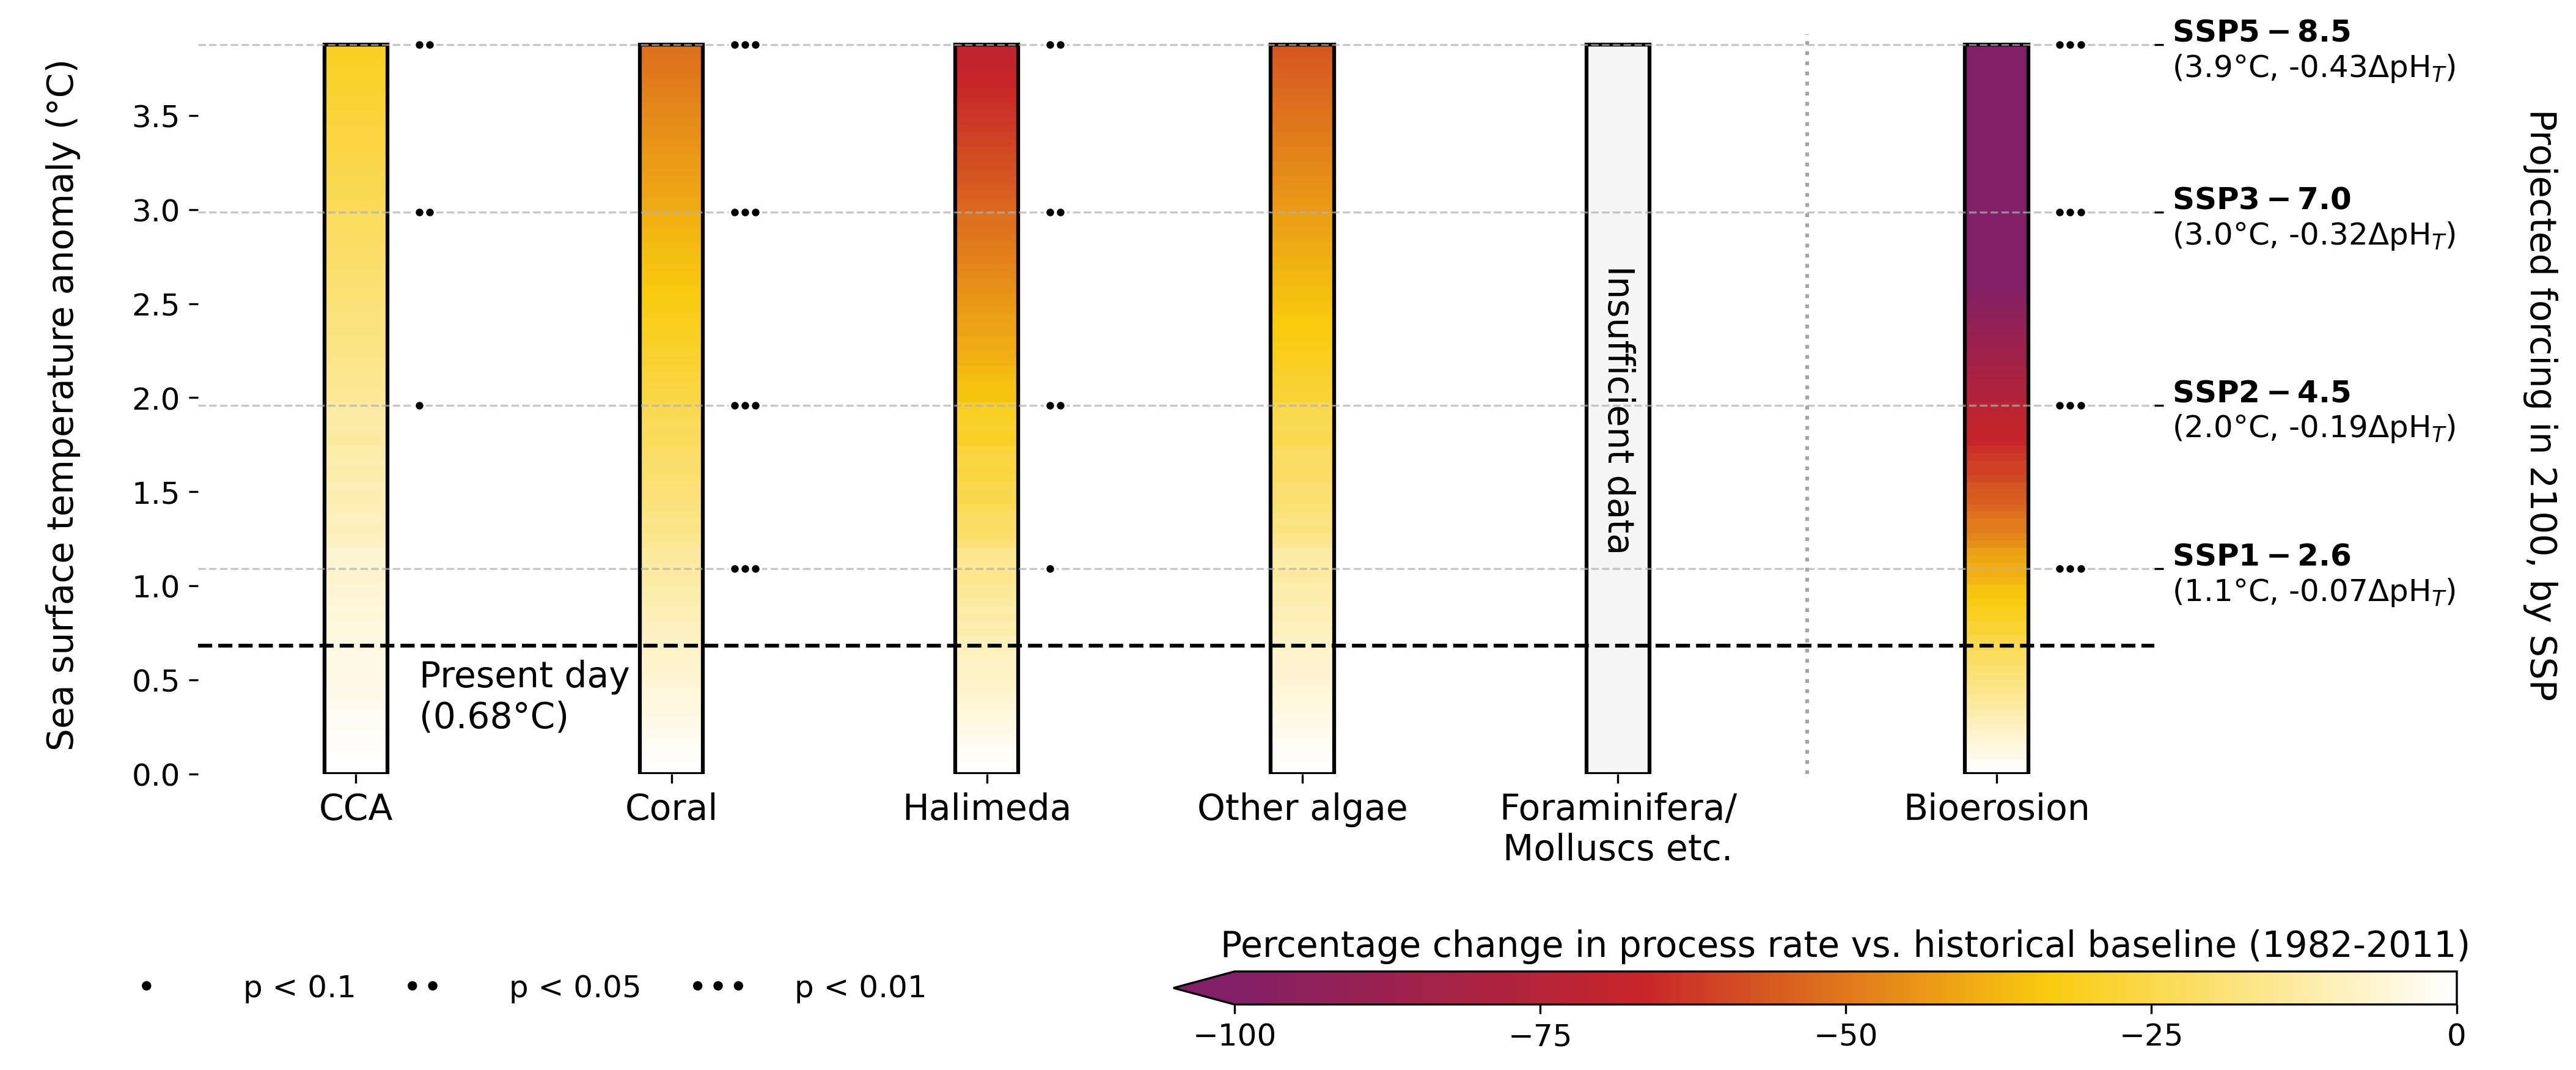

In [116]:
fig, ax = analysis_plot.BurningEmbersPlotter(
    response_df,
    config=analysis_plot.BurningEmbersConfig(
        forcing_col="anomaly_value_sst",
        title="",
        vmin=-100,
        category_order=[
            "CCA",
            "Coral",
            "Halimeda",
            "Other algae",
            "Foraminifera/\nMolluscs etc.",
            "Bioerosion",
        ],
        shift_bioerosion=True,
        pi_exceedance=False,
        se_dots=True,
    ),
).plot()
# plot_utils.save_fig(fig, "FIG_2", file_extension="png")

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/NREE_persistence_reef_structures_meta_analysis/calcification_meta_analysis/processing/climatology.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(


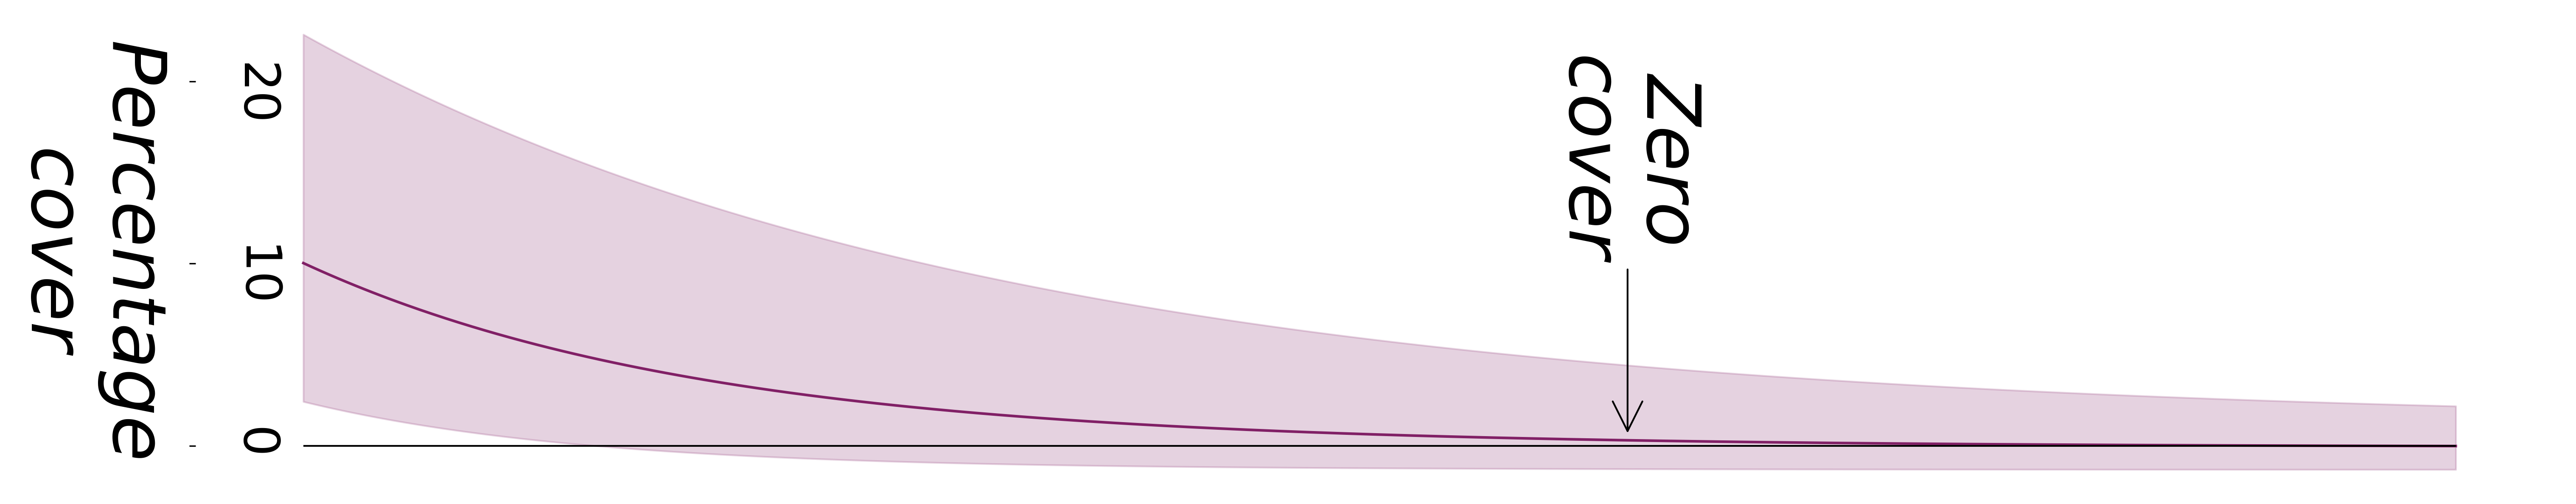

In [117]:
from calcification_meta_analysis.plotting import analysis as analysis_plot

fig, ax = analysis_plot.calculate_and_plot_coral_cover_exponential()
# plot_utils.save_fig(fig, "FIG_2_cover")

# Appendix

Recreating the high-level plots summarising the dataset as a whole.

### Figure S11 – Spatial distribution of study locations

In [118]:
# --- prepare MEOW ocean climatology data --- #
shp_dir_fp = config.climatology_data_dir / "MEOW"
# read in shapefiles from directory
gdf = gpd.read_file(shp_dir_fp / "meow_ecos.shp")
tropical_areas_df = gdf[gdf["Lat_Zone"] == "Tropical"]

tropical_realms = tropical_areas_df.dissolve("REALM")

legend_order = [
    "Eastern Indo-Pacific",
    "Tropical Eastern Pacific",
    "Tropical Atlantic",
    "Western Indo-Pacific",
    "Central Indo-Pacific",
]
# convert the 'REALM' column to a categorical type with the specified order
tropical_areas_df.loc[:, "REALM"] = pd.Categorical(
    tropical_areas_df.loc[:, "REALM"], categories=legend_order, ordered=True
)
tropical_areas_df = tropical_areas_df.sort_values("REALM")
tropical_realms = tropical_areas_df.dissolve("REALM")

In [ ]:
# --- prepare UNEP-WCMC GDCR reef polygons --- #
reef_gdf = gpd.read_file(
    config.data_dir / "UNEP_WCMC" / "WCMC008_CoralReef2021_Py_v4_1.shp"
).to_crs("EPSG:4326")
reefs_simpler = reef_gdf.copy()
reefs_simpler["geometry"] = reefs_simpler["geometry"].simplify(
    tolerance=1, preserve_topology=True
)
# split multipolygons into individual polygons
reefs_simpler = reefs_simpler.copy()
reefs_simpler = gpd.GeoDataFrame(
    reefs_simpler.explode(index_parts=True), geometry="geometry"
)
# buffer the reef polygons to improve visability on the world map
reefs_simpler["geometry"] = reefs_simpler["geometry"].buffer(0.5)
all_reefs = reefs_simpler.dissolve()

In [ ]:
fig, ax = locations.site_distribution_spatial_plot(
    calcification_data_df,
    bioerosion_data_df,
    all_reefs,
    tropical_realms,
    legend_order,
)
# plot_utils.save_fig(fig, "FIG_S11")

### Figure S12 – Temporal distribution of studies included in the analysis, alongside the number of individual samples reported annually between the core taxonomic groupings

In [ ]:
### plot temporal distribution of studies, broken down by species
fig, ax = data_exploration.plot_study_timeseries(
    calcification_data_df, colorby="core_grouping"
)
# plot_utils.save_fig(fig, "FIG_S12")

### Figure S13 – Frequency of species within each core taxonomic grouping

In [ ]:
### plot taxonomic distribution of study organisms
fig, ax = data_exploration.create_faceted_dotplot_with_percentages(
    calcification_data_df, top_n=20, groupby="core_grouping", width=4, height=15
)
# plot_utils.save_fig(fig, "FIG_S13")